In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from astropy.time import Time

from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Define an extra-wide downward bracket "["
bracket_down = Path([
    (-2.0, 0),  # Top-left
    (-2.0, -1),  # Bottom-left
    (2.0, -1),   # Bottom-right
    (2.0, 0),    # Top-right
    (1.6, 0),    # Top-right inner
    (1.6, -0.8), # Bottom-right inner
    (-1.6, -0.8),# Bottom-left inner
    (-1.6, 0),   # Top-left inner
    (-2.0, 0)    # Close path
], [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, 
    Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])

# Define an extra-wide upward bracket "["
bracket_up = Path([
    (-2.0, 0),   # Bottom-left
    (-2.0, 1),   # Top-left
    (2.0, 1),    # Top-right
    (2.0, 0),    # Bottom-right
    (1.6, 0),    # Bottom-right inner
    (1.6, 0.8),  # Top-right inner
    (-1.6, 0.8), # Top-left inner
    (-1.6, 0),   # Bottom-left inner
    (-2.0, 0)    # Close path
], [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, 
    Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])

sys.path.append("/home/jjesus/my_python_modules/")

from myMplStyles import setStyle
from myClasses import profile
from myUsefulFunctions import generate_colormap, fit_linear

setStyle(False)

# Systematic uncertainties in $\rho_{35}$

The purpose of this notebook is to document the calculation of systematic uncertainties in the analysis of $\rho_{35}$ as a function of energy. By systematic uncertainty we refer to the mean systematic uncertainty in each energy bin. Formally, each event has its own systematic uncertainty, and each event-level systematic should be taken into account in an unbinned analysis; this is not the case, since I am not doing any unbinned fit yet.

Depending on how one treats the systematic uncertainty in $\rho_{35}$ caused by the energy scale, one has two options

## Method 1: taken from S. Muller thesis (see p225)

First, we consider the systematics in $\rho_{450}$ without considering the energy scale:

$$\sigma_{\rho_{450}}^2 = \sigma_\text{shape}^2(E) + \sigma_{p_\text{cc}}^2 + \sigma_\text{rec}(E)^2 + \sigma_\text{pattern}(E)^2 + \sigma_\text{fiber}^2,$$

where $\sigma_\text{shape}(E)$ is the systematic due to fixing $\beta$, $\sigma_{p_\text{cc}}$ is the systematic due to the corner-clipping correction, $\sigma_\text{rec}$ is the systematic due to the different reconstruction procedures, $\sigma_\text{pattern}$ is the systematic due to applying a muon pattern of 111x (3 "1s") or 11111x (5 "1s"), and $\sigma_\text{fiber}$ is the uncertainty due to fiber attenuation.

$\rho_{35}$ is obtained via 

$$ \rho_{35} = \frac{1}{f_\text{att}(\theta)}\rho_{450}. $$

Therefore, by propagating the uncertainty, we have 

$$\left( \frac{\sigma_{\rho_{35}}}{\rho_{35}} \right)^2 = \left( \frac{\sigma_{\rho_{450}}}{\rho_{450}} \right)^2  + \left( \frac{\sigma_{f_\text{att}}}{f_\text{att}} \right)^2. $$

Note that $\sigma_{f_\text{att}}$ and $f_\text{att}$ are actually their mean values over the zenith range.

The muon density is normalized by energy, to weaken the energy dependence: 

$$ g \, = \, \rho_{35} \, / \, (E / 10^{18} \text{ eV})^\alpha.$$

Thus, propagating the uncertainty, we have 

$$ \sigma_g ^2 = \left( \frac{\partial g}{\partial \rho_{35}} \right)^2 \sigma_{\rho_{35}}^2 + \left( \frac{\partial g}{\partial E} \right)^2 \sigma_{E}^2 + 2  \frac{\partial g}{\partial \rho_{35}} \frac{\partial g}{\partial E} \text{corr}(\rho_{35}, E) \sigma_{\rho_{35}} \sigma_E,  $$

where I have used that $\text{Cov}(\rho_{35}, E) = \text{corr}(\rho_{35}, E) \sigma_{\rho_{35}} \sigma_E$. The correlation coefficient between $\rho_{35}$ and $E$ can be empirically calculated in each energy bin.

The derivatives are 

$$ \frac{\partial g}{\partial \rho_{35}} = \frac{1}{(E / 10^{18} \text{eV})^\alpha} = \frac{g}{\rho_{35}}, $$

$$ \frac{\partial g}{\partial E} = \frac{(-\alpha)}{E^{\alpha+1}} \frac{\rho_{35}}{(1/10^{18})^\alpha} = -\frac{\alpha}{E} g.$$

Thus, we get 

$$ \sigma_g ^2 = g^2 \left[ \left( \frac{\sigma_{\rho_{35}}}{\rho_{35}} \right)^2 + \alpha^2  \left( \frac{\sigma_{E}}{E}\right)^2  - 2 \, \alpha \, \text{corr}(\rho_{35}, E) \frac{\sigma_{\rho_{35}}}{\rho_{35}} \frac{\sigma_{E}}{E} \right].  $$

## Method 2

Instead of propagating through the correlation of $\rho_{35}$ and $E$, we empirically compute how much $\rho_{35}$ (or $g$) changes when shifting the energy of each event $\pm 14 \%$. The uncertainty thus reads

$$\left( \frac{\sigma_{\rho_{35}}}{\rho_{35}} \right)^2 = \left( \frac{\sigma_{\rho_{450}}}{\rho_{450}} \right)^2  + \left( \frac{\sigma_{f_\text{att}}}{f_\text{att}}  \right)^2 + \left( \frac{\sigma_{\rho_{35}}^\text{energy scale}}{\rho_{35}} \right)^2. $$

# Contributions to the systematic uncertainty

In the following, we detail how to compute the different contributions to the systematic uncertatinty

## shape of MLDF 

This is obtained by re-fitting each event with a shifted $\beta$ given by $\beta = \beta \, (1 + \sigma_{\beta}(E))$.
The relative systematic in $\rho_{450}$ is parameterized as a quadratic function of $\lg (E)$:

$$ \frac{\sigma_{\rho_{450}}}{\rho_{450}} (E) = 0.047 \, (\lg(E/\text{eV})-18)^2 -0.06 \, (\lg(E/\text{eV}) - 18) + 0.036 $$




In [29]:
## code to plot the systematic due to shape of MLDF

## corner-clipping correction

Here we have two contributions: one arising from the statistical uncertainty of the fits of the parameterization of $p_\text{cc}$, and the other due to using the parameterization obtained with simulations.

Lets start with the statistical uncertainty of the fits.

We have 
$$p_\text{cc} = m \, (\sin\Delta \phi - 1 / 2) + b. $$

Thus, propagating we have

$$\sigma_p^2 = \left( \frac{\partial p}{\partial m} \right)^2 \sigma_m^2 + \left( \frac{\partial p}{\partial b} \right)^2 \sigma_b ^ 2\ + 2\text{cov}(m,b) \,\frac{\partial p}{\partial m} \frac{\partial p}{\partial b},$$

where $$ \frac{\partial p}{\partial m} = \sin \Delta \phi - 1/2, $$
$$ \frac{\partial p}{\partial b} = 1. $$ 

In turn, $m$ and $b$ are parameterized as a function of $\theta$: 

$$ m = m_0 + m_1 \, (\sec \theta - 1.2), $$
$$ b = b_0 + b_1 \, (\sec \theta - 1.2). $$

Therefore, 

$$\sigma_m^2 = \left( \frac{\partial m}{\partial m_0} \right)^2 \sigma_{m_0}^2 + \left( \frac{\partial m}{\partial m_1} \right)^2 \sigma_{m_1} ^ 2\ + 2\text{cov}(m_0, m_1) \,\frac{\partial m}{\partial m_0} \frac{\partial m}{\partial m_1},$$

$$\sigma_b^2 = \left( \frac{\partial b}{\partial b_0} \right)^2 \sigma_{b_0}^2 + \left( \frac{\partial b}{\partial b_1} \right)^2 \sigma_{b_1} ^ 2\ + 2\text{cov}(b_0, b_1) \,\frac{\partial b}{\partial b_0} \frac{\partial b}{\partial b_1},$$

where 

$$ \frac{\partial m}{\partial m_0} =  \frac{\partial b}{\partial b_0} = 1,  $$

$$ \frac{\partial m}{\partial m_1} = \frac{\partial b}{\partial b_1}  = \sec \theta - 1.2, $$

and $m_0 = 0.03$, $\sigma_{m_0} = 0.002$, $m_1 = 0.14$, $\sigma_{m_1} = 0.01$, $b_0 = 0.035$, $\sigma_{b_0} = 0.001$, $b_1 = 0.076$ and $\sigma_{b_1} = 0.004$. The covariances are $\text{cov}(m_0, m_1) = 8.9\times10^{-6}$ and $\text{cov}(b_0, b_1) = 7.6\times10^{-7}$.

All the values were taken from the covariance matrix of the fits of $m(\theta)$ and $b(\theta)$ as ouputed by fit_pcc.py in /cr/data01/joaquin/analysis/data_analysis/src/pcc_estimation/:


m = m_0 + m_1* ( sec_theta -1.2 ): covariance matrix of (m1, m0)
[[1.52978168e-04 8.89474098e-06]
 [8.89474098e-06 3.26508200e-06]]


b = b_0 + b_1* ( sec_theta -1.2 ): covariance matrix of (b1, b0)
[[1.49169474e-05 7.61045547e-07]
 [7.61045547e-07 3.15995183e-07]]


cov_matrix_mb =  [[0.00073237 0.00041088]
 [0.00041088 0.00023361]]
cov_mb =  0.00041087796537468235
Index(['sec_theta', 'm', 'm_err', 'b', 'b_err'], dtype='object')


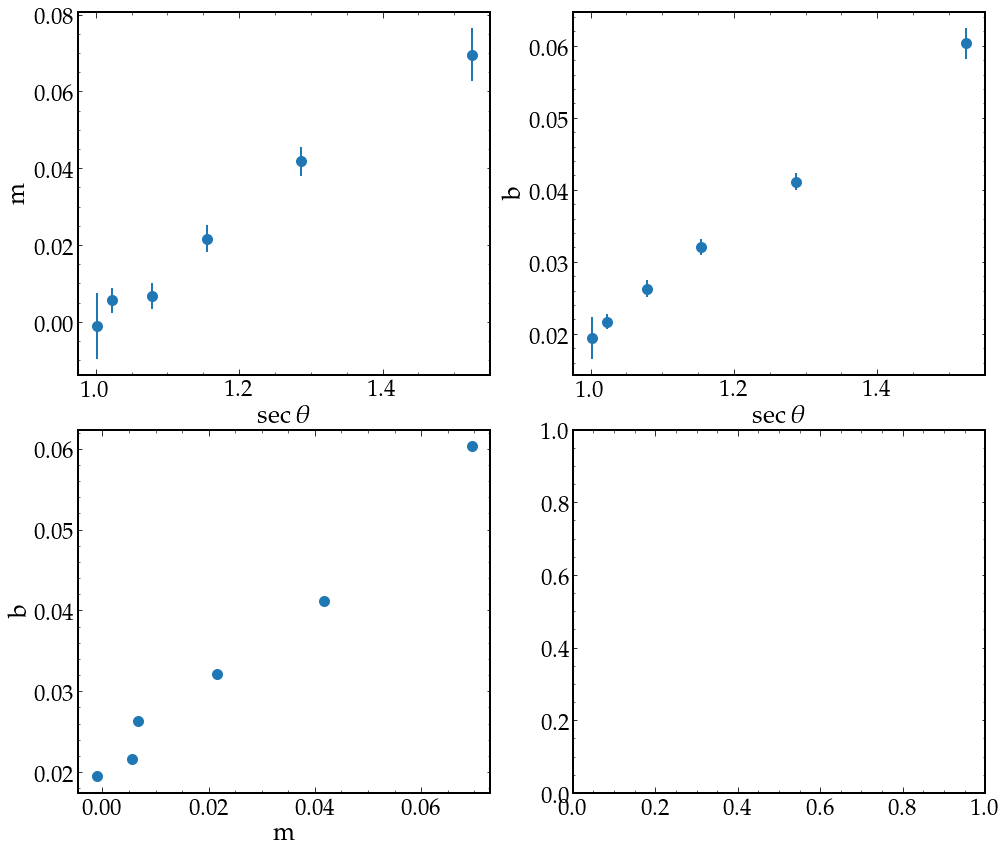

In [49]:
# estimate cov(m, b)

fname = "pcc_fit_parameters_mult2_phase1.dat"
df_params_pcc = pd.read_csv(fname, delim_whitespace=True)


fig, ax = plt.subplots(2, 2, figsize=(18, 14))
ax = ax.flatten()

ax[0].errorbar(df_params_pcc["sec_theta"], df_params_pcc["m"],
           yerr=df_params_pcc["m_err"], fmt="o")
ax[0].set_xlabel(r"$\sec \theta$")
ax[0].set_ylabel("m")

ax[1].errorbar(df_params_pcc["sec_theta"], df_params_pcc["b"],
           yerr=df_params_pcc["b_err"], fmt="o")
ax[1].set_xlabel(r"$\sec \theta$")
ax[1].set_ylabel("b")

cov_matrix_mb = np.cov(df_params_pcc["m"].to_numpy(),
               df_params_pcc["b"].to_numpy())
cov_mb = cov_matrix_mb[0, 1]

print("cov_matrix_mb = ", cov_matrix_mb)
print("cov_mb = ", cov_mb)

ax[2].errorbar(df_params_pcc["m"],
           df_params_pcc["b"], fmt="o")
ax[2].set_xlabel("m")
ax[2].set_ylabel("b")
print(df_params_pcc.columns)

In [59]:
# error in the parameterization of the corner-clipping probability
m0, m1 = 0.03, 0.14
sigma_m0, sigma_m1 = 0.002, 0.01
cov_m0_m1 = 8.9*10**(-6)

b0, b1 = 0.035, 0.076
sigma_b0, sigma_b1 = 0.001, 0.004
cov_b0_b1 = 7.6*10**(-7)

def m_param(theta):
    """
    theta (degrees)
    """
    
    sec = 1 / np.cos(np.deg2rad(theta))
    return m0 + m1*(sec-1.2)

def sigma_m(theta):
    """
    theta (degrees)
    """
    sec = 1 / np.cos(np.deg2rad(theta))
    
    dm_dm0 = 1
    dm_dm1 = (sec-1.2)
    
    value_square = (dm_dm0 * sigma_m0)**2 + (dm_dm1 * sigma_m1)**2 + 2*cov_m0_m1*dm_dm0*dm_dm1 
    return np.sqrt(value_square)
    
def b_param(theta):
    """
    theta (degrees)
    """
    
    sec = 1 / np.cos(np.deg2rad(theta))
    return b0 + b1*(sec-1.2)

def sigma_b(theta):
    """
    theta (degrees)
    """
    sec = 1 / np.cos(np.deg2rad(theta))
    
    db_db0 = 1
    db_db1 = (sec-1.2)
    
    value_square = (db_db0 * sigma_b0)**2 + (db_db1 * sigma_b1)**2 + 2*cov_b0_b1*db_db0*db_db1 
    return np.sqrt(value_square)


def pcc(theta, dphi):
    """
    theta (degrees)
    dphi (degrees)
    """
    m, b = m_param(theta), b_param(theta)
    return m*(np.abs(np.sin(np.deg2rad(dphi))) - 0.5) + b 

def sigma_pcc(theta, dphi):
    """
    I neglect the correlation term for now
    theta (degrees)
    dphi (degrees)
    """

    dp_dm = np.abs(np.sin(np.deg2rad(dphi))) - 0.5
    dp_db = 1
    
    # with this value of covariance, it gives non-sense
    cov_mb_ = 0.0004
    
    value_square = (dp_dm * sigma_m(theta))**2 + (dp_db * sigma_b(theta))**2
    
    return np.sqrt(value_square)

# just to compare, I plot the old pcc parameterizatin

def pcc_old(theta, dphi):
    """
    theta (degrees)
    dphi (degrees)
    """
    sec = 1 / np.cos(np.deg2rad(theta))
    
    m_old = -0.15 + 0.1462*sec 
    b_old = 0.02
    
    return b_old + m_old*np.abs(np.sin(np.deg2rad(dphi)))
    

sigma_p_check = 0.018909293957708552


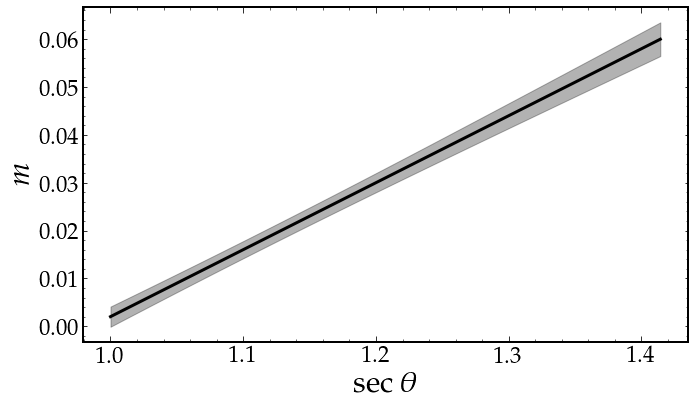

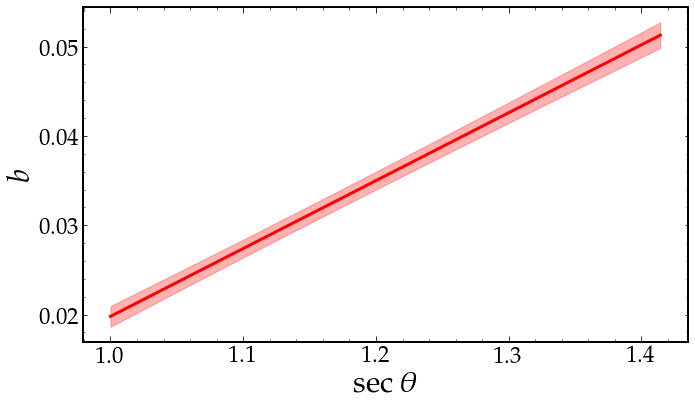

In [53]:
## plot uncertainty band in m(theta) and b(theta)


theta_plot = np.linspace(0, 45, 400)
sec_plot = 1 / np.cos(np.deg2rad(theta_plot))

# m
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
m_plot = m_param(theta_plot)
sigma_m_plot = [sigma_m(th) for th in theta_plot]

ax.plot(sec_plot, m_plot, color="k", lw=3)
ax.fill_between(sec_plot, m_plot - sigma_m_plot, m_plot + sigma_m_plot,
                  color="k", alpha=0.3)
ax.set_xlabel(r"$\sec \theta$", fontsize=30)
ax.set_ylabel(r"$m$", fontsize=30)

figname = "m_uncertainty_band.pdf"
fig.savefig(figname, bbox_inches="tight")

# b
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
b_plot = b_param(theta_plot)
sigma_b_plot = [sigma_b(th) for th in theta_plot]

ax.plot(sec_plot, b_plot, color="r", lw=3)
ax.fill_between(sec_plot, b_plot - sigma_b_plot, b_plot + sigma_b_plot,
                  color="r", alpha=0.3)
ax.set_xlabel(r"$\sec \theta$", fontsize=30)
ax.set_ylabel(r"$b$", fontsize=30)

figname = "b_uncertainty_band.pdf"
fig.savefig(figname, bbox_inches="tight")


# just a check
sigma_p_check = sigma_pcc(theta=np.rad2deg(np.arccos(0.865179)), dphi=(106.108--3))
print(f"sigma_p_check = {sigma_p_check}")

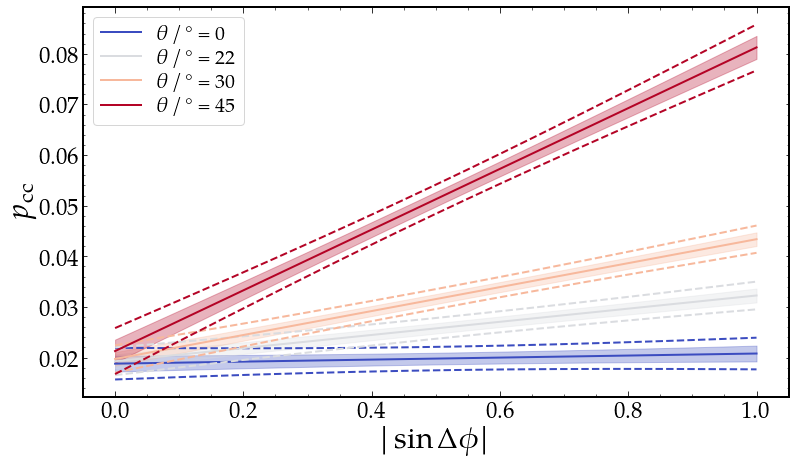

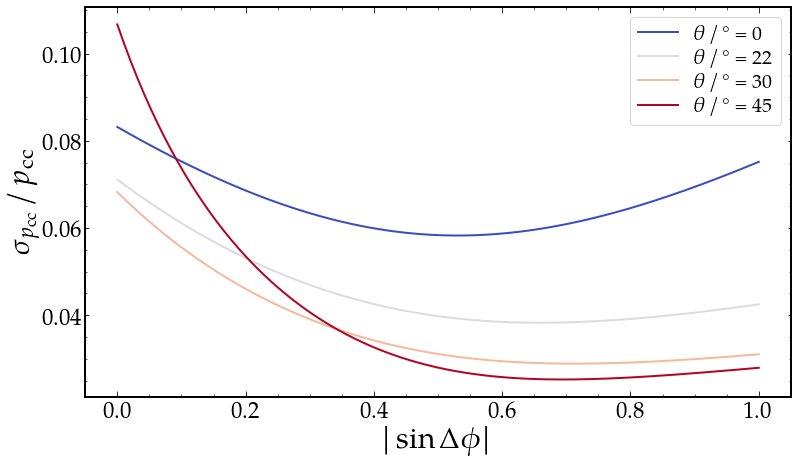

In [60]:
## uncertainty bands in pcc for different thetas
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# relative uncertainty
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 7))

theta_values = [0, 22, 30, 45]
dphi_plot = np.linspace(0, 90, 300)
sindphi_plot = np.abs(np.sin(np.deg2rad(dphi_plot)))

cmap_theta = generate_colormap(theta_values)
for theta in theta_values:
    lbl = r"$\theta \, / \, ^\circ$ = " + f"{theta:.0f}"
    clr = cmap_theta.to_rgba(theta)
    pcc_plot = pcc(theta=theta, dphi=dphi_plot)
    
    sigma_pcc_plot = np.array([sigma_pcc(theta=theta, dphi=dd) for dd in dphi_plot])
    #print(sigma_pcc_plot)
    
    
    ax.plot(sindphi_plot, pcc_plot, "-", label=lbl, color=clr, lw=2)
    
    # 1 sigma
    ax.fill_between(sindphi_plot, pcc_plot-sigma_pcc_plot, pcc_plot+sigma_pcc_plot,
                   alpha=0.3, color=clr)
    # 2 sigma 
    ax.plot(sindphi_plot, pcc_plot+2*sigma_pcc_plot, "--", color=clr)
    ax.plot(sindphi_plot, pcc_plot-2*sigma_pcc_plot, "--", color=clr)
    
    # 3 sigma 
    #ax[0].plot(sindphi_plot, pcc_plot+3*sigma_pcc_plot, "-.", color=clr)
    #ax[0].plot(sindphi_plot, pcc_plot-3*sigma_pcc_plot, "-.", color=clr)
    
    # old parameterization
    pcc_old_plot = pcc_old(theta=theta, dphi=dphi_plot)
    #ax[0].plot(sindphi_plot, pcc_old_plot, "-.")
    
    rel_sigma_plot = sigma_pcc_plot / pcc_plot
    ax2.plot(sindphi_plot, rel_sigma_plot, label=lbl, color=clr)
    
ax.set_xlabel(r"$| \sin\Delta\phi |$", fontsize=30)
ax.set_ylabel(r"$p_\text{cc}$", fontsize=30)
ax.legend()

figname = "pcc_uncertainty_bands.pdf"
fig.savefig(figname, bbox_inches="tight")
    
ax2.set_xlabel(r"$| \sin\Delta\phi |$", fontsize=30)
ax2.set_ylabel(r"$\sigma_{p_\text{cc}} \, / \, p_\text{cc}$", fontsize=30)
ax2.legend()
    

The reconstruction of the whole dataset was repeated but with a $\tilde{p}_\text{cc} = p_\text{cc}(\theta, \Delta\phi) \pm 2\sigma_p(\theta, \Delta \phi)$. In addition, we also reconstruct the data but with the parameterization of $p_\text{cc}$ obtained for simulations.

In [3]:
# directory where to find the unbinned dataset in each reconstruction
input_dir = "./different_reconstructions"

df_official = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                         delim_whitespace=True)
df_official = df_official[ df_official["lge"] > 17.3 ]
print(f"events with the official pcc = {len(df_official)}")

# pcc + 2sigma
df_2sigma_plus = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50_pcc_2sigma_plus.dat",
                         delim_whitespace=True)
df_2sigma_plus = df_2sigma_plus[ df_2sigma_plus["lge"] > 17.3 ]
print(f"events with the pcc + 2sigma = {len(df_2sigma_plus)}")

# pcc - 2sigma
df_2sigma_minus = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50_pcc_2sigma_minus.dat",
                         delim_whitespace=True)
df_2sigma_minus = df_2sigma_minus[ df_2sigma_minus["lge"] > 17.3 ]
print(f"events with the pcc - 2sigma = {len(df_2sigma_minus)}")

# pcc of simulations
df_sim = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50_pcc_sim.dat",
                         delim_whitespace=True)
df_sim = df_sim[ df_sim["lge"] > 17.3 ]
print(f"events with the pcc simulations = {len(df_sim)}")

# looking for events that are in the official, but not in pcc - 2sigma (idk why this happens)
difference = np.setdiff1d(df_official["event_id"].to_numpy(), df_2sigma_minus["event_id"].to_numpy())
print("Elements in official pcc but not in pcc - 2sigma:", difference)

# looking for events that are in the official, but not in pcc of simulations (idk why this happens)
difference2 = np.setdiff1d(df_official["event_id"].to_numpy(), df_sim["event_id"].to_numpy())
print("Elements in official pcc but not in pcc sim:", difference2)

# filter this event from all dataframes
events_to_filter = np.concatenate((difference, difference2))
print("events to filter: ", events_to_filter)
print("\n")

## removing offending events from all dataframes
df_official = df_official[ ~df_official["event_id"].isin(events_to_filter) ]
df_2sigma_plus = df_2sigma_plus[ ~df_2sigma_plus["event_id"].isin(events_to_filter) ]
df_2sigma_minus = df_2sigma_minus[ ~df_2sigma_minus["event_id"].isin(events_to_filter) ]
df_sim = df_sim[ ~df_sim["event_id"].isin(events_to_filter) ]

print("\n")
print("after cleaning")
print(f"events with the official pcc = {len(df_official)}")
print(f"events with the pcc + 2sigma = {len(df_2sigma_plus)}")
print(f"events with the pcc - 2sigma = {len(df_2sigma_minus)}")
print(f"events with the pcc simulations = {len(df_sim)}")

## just checking that each dataset has the same events
assert (df_official["event_id"].to_numpy() == df_2sigma_plus["event_id"].to_numpy()).all()
assert (df_official["event_id"].to_numpy() == df_2sigma_minus["event_id"].to_numpy()).all()
assert (df_official["event_id"].to_numpy() == df_sim["event_id"].to_numpy()).all()

assert (df_official["yymmdd"].to_numpy() == df_2sigma_plus["yymmdd"].to_numpy()).all()
assert (df_official["yymmdd"].to_numpy() == df_2sigma_minus["yymmdd"].to_numpy()).all()
assert (df_official["yymmdd"].to_numpy() == df_sim["yymmdd"].to_numpy()).all()

print(df_official.columns)

events with the official pcc = 13256
events with the pcc + 2sigma = 13256
events with the pcc - 2sigma = 13255
events with the pcc simulations = 13255
Elements in official pcc but not in pcc - 2sigma: ['auger_212872347200__sd_65358869__md_999']
Elements in official pcc but not in pcc sim: ['auger_213173358200__sd_65756215__md_1450']
events to filter:  ['auger_212872347200__sd_65358869__md_999'
 'auger_213173358200__sd_65756215__md_1450']




after cleaning
events with the official pcc = 13254
events with the pcc + 2sigma = 13254
events with the pcc - 2sigma = 13254
events with the pcc simulations = 13254
Index(['event_id', 'yymmdd', 'lge', 'theta', 'rho450', 'rho450_err',
       'rho_att_corrected', 'rho_att_corrected_err'],
      dtype='object')


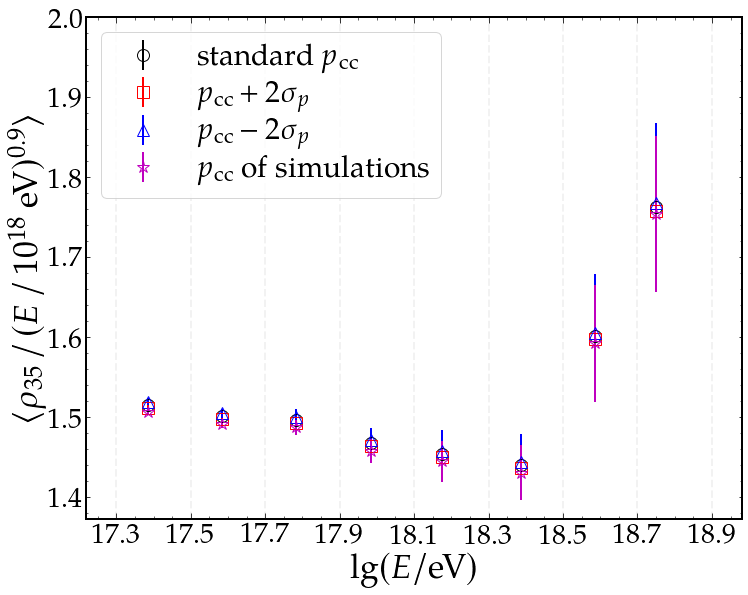

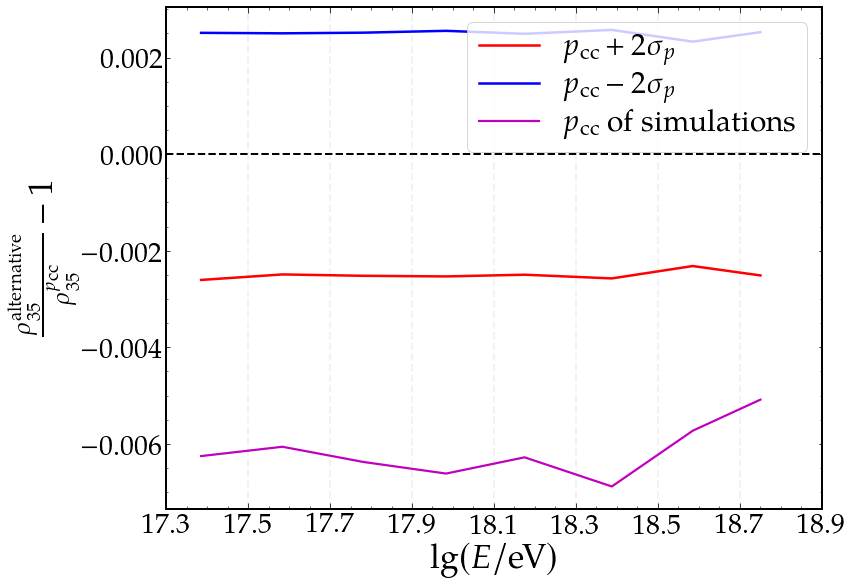

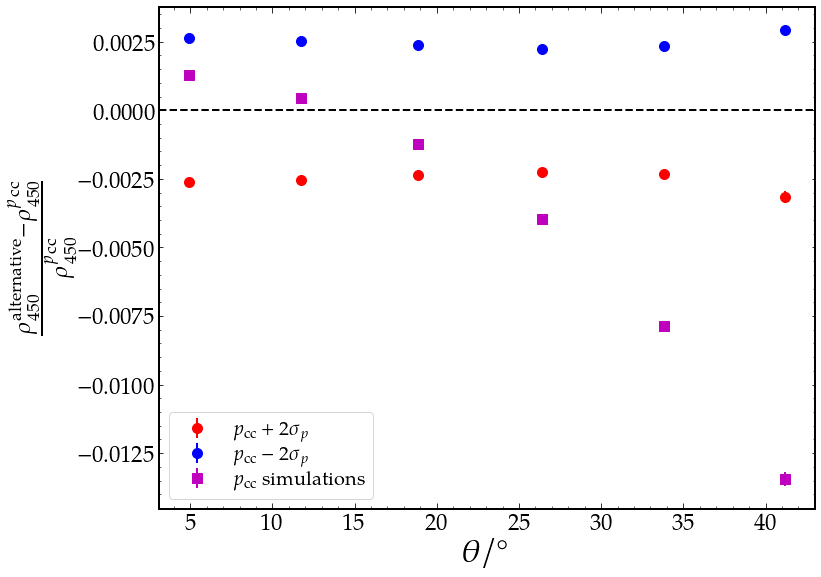

In [54]:
## compare rho450 with pcc official and pcc +- 2sigma

# edges of the energy binning for the profile
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9]

color_standard = "k"
color_plus = "r"
color_minus = "b"
color_sim = "m"

alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_official = ((10**df_official["lge"].to_numpy()) / (10**(18)) )**alpha
rho_official_norm = df_official["rho_att_corrected"].to_numpy() / norm_factor_official
p_norm_official = profile(df_official["lge"].to_numpy(), rho_official_norm)
p_norm_official.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_2sigma_plus = ((10**df_2sigma_plus["lge"].to_numpy()) / (10**(18)) )**alpha
rho_2sigma_plus_norm = df_2sigma_plus["rho_att_corrected"].to_numpy() / norm_factor_2sigma_plus
p_norm_2sigma_plus = profile(df_2sigma_plus["lge"].to_numpy(), rho_2sigma_plus_norm)
p_norm_2sigma_plus.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_2sigma_minus = ((10**df_2sigma_minus["lge"].to_numpy()) / (10**(18)) )**alpha
rho_2sigma_minus_norm = df_2sigma_minus["rho_att_corrected"].to_numpy() / norm_factor_2sigma_minus
p_norm_2sigma_minus = profile(df_2sigma_minus["lge"].to_numpy(), rho_2sigma_minus_norm)
p_norm_2sigma_minus.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_sim = ((10**df_sim["lge"].to_numpy()) / (10**(18)) )**alpha
rho_sim_norm = df_sim["rho_att_corrected"].to_numpy() / norm_factor_sim
p_norm_sim = profile(df_sim["lge"].to_numpy(), rho_sim_norm)
p_norm_sim.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax.errorbar(p_norm_official.profilexmean, p_norm_official.profiley, 
            yerr=p_norm_official.profileyerr,
           fmt="o", label=r"standard $p_\text{cc}$", mfc="None",
           ms=12, color=color_standard)

ax.errorbar(p_norm_2sigma_plus.profilexmean, p_norm_2sigma_plus.profiley, 
            yerr=p_norm_2sigma_plus.profileyerr,
           fmt="s", label=r"$p_\text{cc} + 2\sigma_p$", mfc="None", ms=12,
           color=color_plus)

ax.errorbar(p_norm_2sigma_minus.profilexmean, p_norm_2sigma_minus.profiley, 
            yerr=p_norm_2sigma_minus.profileyerr,
           fmt="^", label=r"$p_\text{cc} - 2\sigma_p$", mfc="None", ms=12,
           color=color_minus)

ax.errorbar(p_norm_sim.profilexmean, p_norm_sim.profiley, 
            yerr=p_norm_sim.profileyerr,
           fmt="*", label=r"$p_\text{cc}$ of simulations", mfc="None", ms=12,
           color=color_sim)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=34)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=34)
ax.set_xticks(lge_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho35_norm_pcc_sys.pdf"
fig.savefig(figname, bbox_inches="tight")

###
# ratio of profiles
ratio_2sigma_plus = np.array(p_norm_2sigma_plus.profiley) / np.array(p_norm_official.profiley) 
ratio_2sigma_minus =  np.array(p_norm_2sigma_minus.profiley) / np.array(p_norm_official.profiley) 
ratio_sim =  np.array(p_norm_sim.profiley) / np.array(p_norm_official.profiley)

ratio_2sigma_plus_err = ratio_2sigma_plus * np.sqrt((np.array(p_norm_official.profileyerr) / np.array(p_norm_official.profiley))**2 +
                                       (np.array(p_norm_2sigma_plus.profileyerr) / np.array(p_norm_2sigma_plus.profiley))**2)

ratio_2sigma_minus_err = ratio_2sigma_minus * np.sqrt((np.array(p_norm_official.profileyerr) / np.array(p_norm_official.profiley))**2 +
                                       (np.array(p_norm_2sigma_minus.profileyerr) / np.array(p_norm_2sigma_minus.profiley))**2)

fig, ax = plt.subplots(1, 1, figsize=(13, 9))

# plotting the statistical error of the ratio
#ax.errorbar(p_norm_official.profilexmean, ratio_2sigma_plus-1,
            #yerr=ratio_2sigma_plus_err, label=r"$p_\text{cc} + 2\sigma_p$")
#ax.errorbar(p_norm_official.profilexmean, ratio_2sigma_minus-1, 
            #yerr=ratio_2sigma_minus_err, label=r"$p_\text{cc} - 2\sigma_p$")

# without ploting statistical error of the ratio
ax.errorbar(p_norm_official.profilexmean, ratio_2sigma_plus-1,
            label=r"$p_\text{cc} + 2\sigma_p$", lw=2.5, color=color_plus)
ax.errorbar(p_norm_official.profilexmean, ratio_2sigma_minus-1, 
            label=r"$p_\text{cc} - 2\sigma_p$", lw=2.5, color=color_minus)
ax.errorbar(p_norm_sim.profilexmean, ratio_sim-1, 
            label=r"$p_\text{cc}$ of simulations", lw=2.2, color=color_sim)

ax.axhline(y=0, ls="--", color="k")
ax.set_xticks(lge_bin_edges)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=34)
ax.set_ylabel(r"$\frac{\rho_{35}^\text{alternative}}{\rho_{35}^{p_\text{cc}}} -1$", fontsize=34)
ax.legend(fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho35_ratio_pcc_sys.pdf"
fig.savefig(figname, bbox_inches="tight")

# drho450 as a function of theta 

drho450_2sigma_plus =  (df_2sigma_plus["rho450"].to_numpy() - df_official["rho450"].to_numpy()) / df_official["rho450"].to_numpy()
drho450_2sigma_minus =  (df_2sigma_minus["rho450"].to_numpy() - df_official["rho450"].to_numpy()) / df_official["rho450"].to_numpy()
drho450_sim =  (df_sim["rho450"].to_numpy() - df_official["rho450"].to_numpy()) / df_official["rho450"].to_numpy()


theta_bins = list(np.linspace(0, 45, 7))
p_plus = profile(df_official["theta"].to_numpy(), drho450_2sigma_plus)
p_plus.doProfile(xmin=min(theta_bins), xmax=max(theta_bins), bins=theta_bins)

p_minus = profile(df_official["theta"].to_numpy(), drho450_2sigma_minus)
p_minus.doProfile(xmin=min(theta_bins), xmax=max(theta_bins), bins=theta_bins)

p_sim = profile(df_official["theta"].to_numpy(), drho450_sim)
p_sim.doProfile(xmin=min(theta_bins), xmax=max(theta_bins), bins=theta_bins)

fig, ax = plt.subplots(1, 1, figsize=(13, 9))

ax.errorbar(p_plus.profilexmean, p_plus.profiley, p_plus.profileyerr, fmt="o",
           label=r"$p_\text{cc} + 2\sigma_p$", ms=10, color=color_plus)
ax.errorbar(p_minus.profilexmean, p_minus.profiley, p_minus.profileyerr, fmt="o",
           label=r"$p_\text{cc} - 2\sigma_p$", ms=10, color=color_minus)
ax.errorbar(p_sim.profilexmean, p_sim.profiley, p_sim.profileyerr, fmt="s",
           label=r"$p_\text{cc}$ simulations", ms=10, color=color_sim)

ax.set_xlabel(r"$\theta / ^\circ$", fontsize=32)
ax.set_ylabel(r"$\frac{\rho_{450}^\text{alternative} - \rho_{450}^{p_\text{cc}}}{\rho_{450}^{p_\text{cc}}}$",
             fontsize=32)
ax.axhline(y=0, ls="--", color="k")
ax.legend()

It is evident that regardless of which corner-clipping correction one uses, the final impact in $\rho_{450}$ is negligible. This can be explained by looking at the binomial likelihood:

pcc_base = 0.10
pcc_minus = 0.07
pcc_base_plus = 0.13


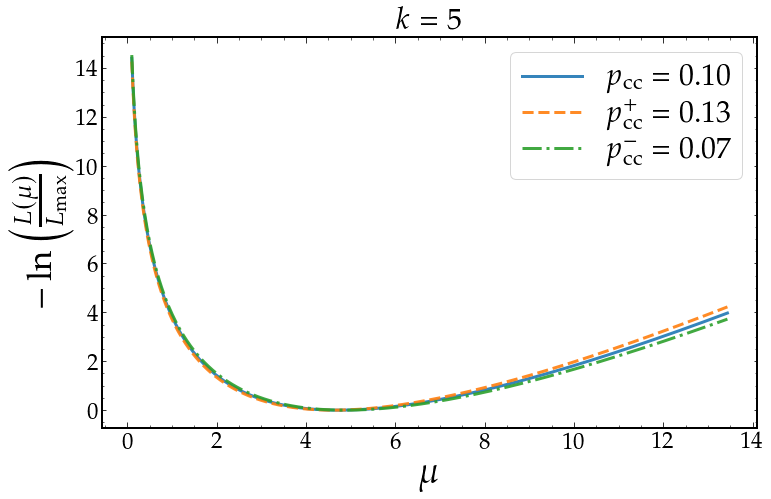

In [59]:
# -ln(L / Lmax)
def logLikeRatioBinom(k, mu, pcc, n=64):
    """
    Binomial log-likelihood ratio
    """
    return mu*(1+pcc) - k*( np.log(np.exp(mu*(1+pcc)/n) - 1) - np.log((k/n)/(1-(k/n))) ) + n*np.log(1-k/n)

k_obs = 5

pcc_base = 0.1
pcc_base_minus = pcc_base*0.7
pcc_base_plus = pcc_base*1.3 

print(f"pcc_base = {pcc_base:.2f}")
print(f"pcc_minus = {pcc_base_minus:.2f}")
print(f"pcc_base_plus = {pcc_base_plus:.2f}")

# plot values for mu
mu_ml = -64*np.log(1-k_obs/64) / (1+pcc_base)
mu_min = max(0.1, mu_ml - 3*np.sqrt(mu_ml))
mu_max = mu_ml + 4*np.sqrt(mu_ml)
mu_plot = np.linspace(mu_min, mu_max, 500)

# binomial log like 
binom_log_like_base = [logLikeRatioBinom(k=k_obs, mu=muu, pcc=pcc_base) for muu in mu_plot]
binom_log_like_base_minus = [logLikeRatioBinom(k=k_obs, mu=muu, pcc=pcc_base_minus) for muu in mu_plot]
binom_log_like_base_plus = [logLikeRatioBinom(k=k_obs, mu=muu, pcc=pcc_base_plus) for muu in mu_plot]

fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(mu_plot, binom_log_like_base, label=rf"$p_\text{{cc}} = {pcc_base:.2f}$", lw=3, alpha=0.9,
       )
ax.plot(mu_plot, binom_log_like_base_plus, label=rf"$p_\text{{cc}}^{{+}} = {pcc_base_plus:.2f}$", 
        lw=3, alpha=0.9, ls="--")
ax.plot(mu_plot, binom_log_like_base_minus, label=rf"$p_\text{{cc}}^{{-}} = {pcc_base_minus:.2f}$", 
        lw=3, alpha=0.9, ls="-.")

ax.set_xlabel(r"$\mu$", fontsize=35)
ax.set_ylabel(r"$-\ln \left( \frac{L(\mu)}{L_\text{max}} \right)$",
             fontsize=35)
ax.set_title(rf"$k = {k_obs}$", fontsize=30)

ax.legend(fontsize=30)

figname = f"log_like_k{k_obs}_pcc.pdf"
fig.savefig(figname, bbox_inches="tight")


## reconstruction procedure

In this case, the entire data production of phase 1 is ran but with different reconstruction configurations: 

| UMD core | LDF slope | config |
|----------|----------|----------|
| free    | fixed   | standard   |
| fixed    | fixed   | non-standard   |
| fixed   | free  | non-standard |

The standard reconstruction leaves the UMD core free and the LDF slope fixed to a parameterized value. We try two additional configurations, namely, with the UMD core and LDF slope fixed and with the UMD core fixed with the slope free in every event. Freeing both the core and the slope is not feasible. The maximum difference of $\langle \rho_{35} \rangle$ between the reconstructions in each energy bin serves as a measure of the systematic uncertainty due to the reconstruction configuration.

In [2]:
# directory where to find the unbinned dataset in each reconstruction
input_dir = "./different_reconstructions"

# standard 
df_standard = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                         delim_whitespace=True)
df_standard = df_standard[ df_standard["lge"] > 17.3 ]
print(f"events with the standard reco = {len(df_standard)}")

# core and beta fixed 
df_fixed = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta1_time0_like3_fixCore1_useSil0_nOnes4_md6t50.dat",
                         delim_whitespace=True)
df_fixed = df_fixed[ df_fixed["lge"] > 17.3 ]
print(f"events with core and beta fixed = {len(df_fixed)}")

# core fixed, beta free
df_free = pd.read_csv(input_dir + "/unbinned_dataset_fixBeta0_time0_like3_fixCore1_useSil0_nOnes4_md6t50.dat",
                         delim_whitespace=True)
df_free = df_free[ df_free["lge"] > 17.3 ]

print(f"events with core fixed and beta free = {len(df_free)}")

## just checking that each dataset has the same events
assert (df_standard["event_id"].to_numpy() == df_fixed["event_id"].to_numpy()).all()
assert (df_standard["event_id"].to_numpy() == df_free["event_id"].to_numpy()).all()

assert (df_standard["yymmdd"].to_numpy() == df_fixed["yymmdd"].to_numpy()).all()
assert (df_standard["yymmdd"].to_numpy() == df_free["yymmdd"].to_numpy()).all()

print(df_standard.columns)

events with the standard reco = 13256
events with core and beta fixed = 13256
events with core fixed and beta free = 13256
Index(['event_id', 'yymmdd', 'lge', 'theta', 'rho450', 'rho450_err',
       'rho_att_corrected', 'rho_att_corrected_err'],
      dtype='object')


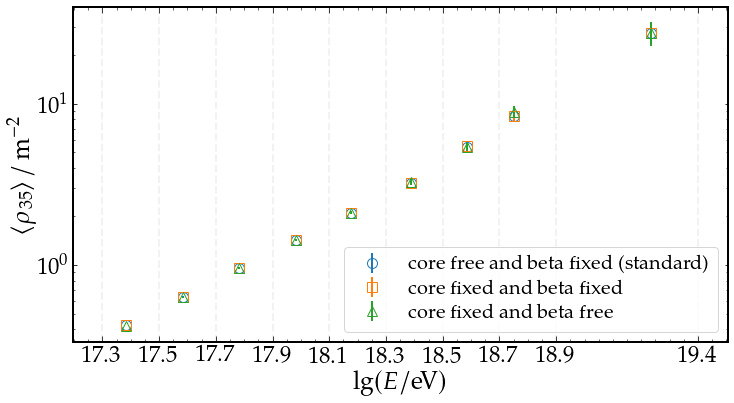

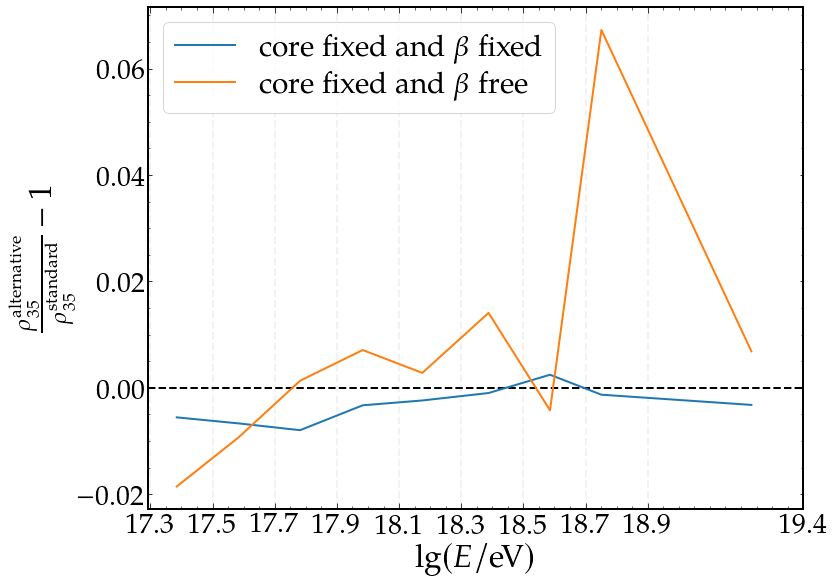

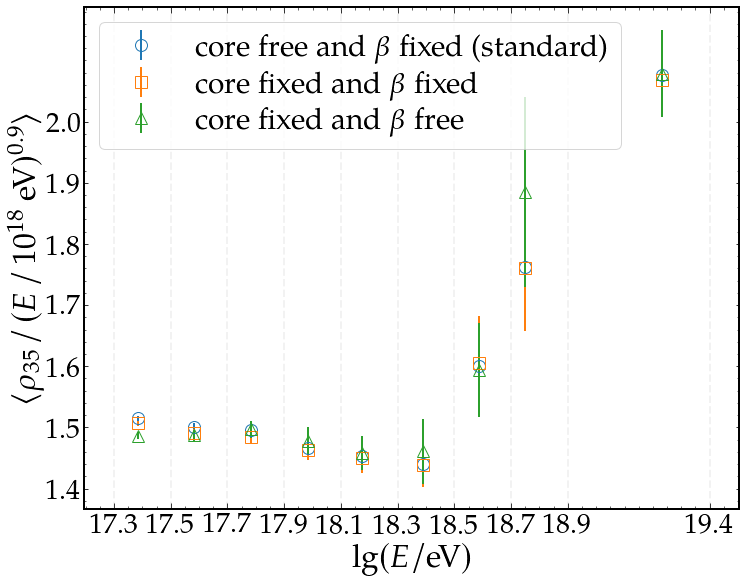

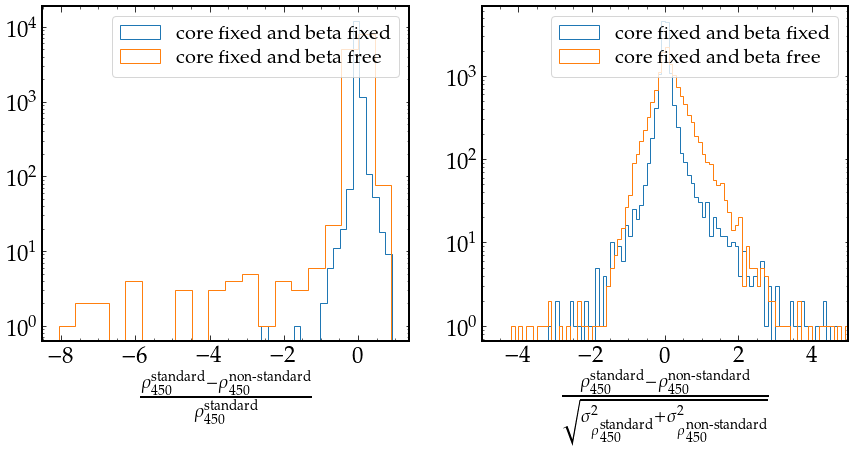

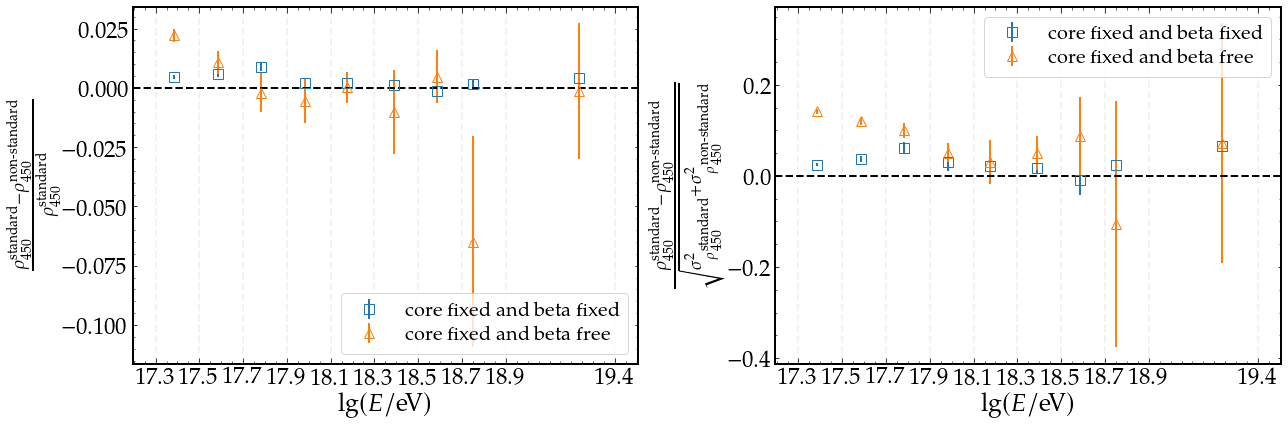

In [5]:
# edges of the energy binning for the profile
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.4]

# rho35 vs lg(E)
p_standard = profile(x=df_standard["lge"].to_numpy(), y=df_standard["rho_att_corrected"].to_numpy(),
                    yerr=df_standard["rho_att_corrected_err"].to_numpy())
p_standard.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p_fixed = profile(x=df_fixed["lge"].to_numpy(), y=df_fixed["rho_att_corrected"].to_numpy(),
                 yerr=df_fixed["rho_att_corrected_err"].to_numpy())
p_fixed.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p_free = profile(x=df_free["lge"].to_numpy(), y=df_free["rho_att_corrected"].to_numpy(),
                yerr=df_fixed["rho_att_corrected_err"].to_numpy())
p_free.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))

ax.errorbar(p_standard.profilexmean, p_standard.profiley, yerr=p_standard.profileyerr,
           fmt="o", label="core free and beta fixed (standard)", mfc="None",
           )

ax.errorbar(p_fixed.profilexmean, p_fixed.profiley, yerr=p_fixed.profileyerr,
           fmt="s", label="core fixed and beta fixed", mfc="None")

ax.errorbar(p_free.profilexmean, p_free.profiley, yerr=p_free.profileyerr,
           fmt="^", label="core fixed and beta free", mfc="None")

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$")
ax.set_ylabel(r"$\langle \rho_{35} \rangle \, / \, \text{m}^{-2}$")
ax.set_yscale("log")
ax.set_xticks(lge_bin_edges)
ax.legend()

# ratio of profiles
ratio_fixed = np.array(p_fixed.profiley) / np.array(p_standard.profiley) 
ratio_free =  np.array(p_free.profiley) / np.array(p_standard.profiley) 

ratio_fixed_err = ratio_fixed * np.sqrt((np.array(p_standard.profileyerr) / np.array(p_standard.profiley))**2 +
                                       (np.array(p_fixed.profileyerr) / np.array(p_fixed.profiley))**2)

ratio_free_err = ratio_free * np.sqrt((np.array(p_standard.profileyerr) / np.array(p_standard.profiley))**2 +
                                       (np.array(p_free.profileyerr) / np.array(p_free.profiley))**2)

fig, ax = plt.subplots(1, 1, figsize=(13, 9))

# plotting the statistical error of the ratio
#ax.errorbar(p_standard.profilexmean, ratio_fixed-1,
            #yerr=ratio_fixed_err, label=r"core fixed and $\beta$ fixed")
#ax.errorbar(p_standard.profilexmean, ratio_free-1, 
            #yerr=ratio_free_err, label=r"core fixed and $\beta$ free")

# without ploting statistical error of the ratio
ax.errorbar(p_standard.profilexmean, ratio_fixed-1,
            label=r"core fixed and $\beta$ fixed", lw=2)
ax.errorbar(p_standard.profilexmean, ratio_free-1, 
            label=r"core fixed and $\beta$ free", lw=2)

ax.axhline(y=0, ls="--", color="k")
ax.set_xticks(lge_bin_edges)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(r"$\frac{\rho_{35}^\text{alternative}}{\rho_{35}^\text{standard}} -1$", fontsize=32)
ax.legend(fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "ratio_rho35_reconstructions.pdf"
fig.savefig(figname, bbox_inches="tight")

# profile of rho35 / (E/10**18)**alpha 
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_standard = ((10**df_standard["lge"].to_numpy()) / (10**(18)) )**alpha
rho_standard_norm = df_standard["rho_att_corrected"].to_numpy() / norm_factor_standard
rho_standard_norm_err = df_standard["rho_att_corrected_err"].to_numpy() / norm_factor_standard
p_norm_standard = profile(x=df_standard["lge"].to_numpy(), y=rho_standard_norm,
                         yerr=rho_standard_norm_err)
p_norm_standard.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_fixed = ( (10**df_fixed["lge"].to_numpy()) / (10**(18)) )**alpha
rho_fixed_norm = df_fixed["rho_att_corrected"].to_numpy() / norm_factor_fixed
rho_fixed_norm_err = df_fixed["rho_att_corrected_err"].to_numpy() / norm_factor_fixed
p_norm_fixed = profile(x=df_fixed["lge"].to_numpy(), y=rho_fixed_norm,
                      yerr=rho_fixed_norm_err)
p_norm_fixed.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_free = ( (10**df_free["lge"].to_numpy()) / (10**(18)) )**alpha
rho_free_norm = df_free["rho_att_corrected"].to_numpy() / norm_factor_free
rho_free_norm_err = df_free["rho_att_corrected_err"].to_numpy() / norm_factor_free
p_norm_free = profile(x=df_free["lge"].to_numpy(), y=rho_free_norm,
                     yerr=rho_free_norm_err)
p_norm_free.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax.errorbar(p_norm_standard.profilexmean, p_norm_standard.profiley, yerr=p_norm_standard.profileyerr,
           fmt="o", label=r"core free and $\beta$ fixed (standard)", mfc="None",
           ms=12)

ax.errorbar(p_norm_fixed.profilexmean, p_norm_fixed.profiley, yerr=p_norm_fixed.profileyerr,
           fmt="s", label=r"core fixed and $\beta$ fixed", mfc="None", ms=12)

ax.errorbar(p_norm_free.profilexmean, p_norm_free.profiley, yerr=p_norm_free.profileyerr,
           fmt="^", label=r"core fixed and $\beta$ free", mfc="None", ms=12)

# weighted mean - se ven raros
#ax.errorbar(p_norm_standard.profilexmean, p_norm_standard.profileyweighted, 
            #yerr=p_norm_standard.profileyweightederr,
           #fmt="o", label=r"core free and $\beta$ fixed (standard) - weighted mean", mfc="None",
           #ms=12)
#ax.errorbar(p_norm_fixed.profilexmean, p_norm_fixed.profileyweighted, 
            #yerr=p_norm_fixed.profileyweightederr,
           #fmt="s", label=r"core fixed and $\beta$ fixed - weighted mean", mfc="None", ms=12)

#ax.errorbar(p_norm_free.profilexmean, p_norm_free.profileyweighted, 
            #yerr=p_norm_free.profileyweightederr,
           #fmt="^", label=r"core fixed and $\beta$ free - weighted mean", mfc="None", ms=12)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(lge_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho35_reconstructions.pdf"
fig.savefig(figname, bbox_inches="tight")

#######################################################
# histogram of drho450 normalized by rho450_standard
drho450_fixed = (df_standard["rho450"].to_numpy() - df_fixed["rho450"].to_numpy()) / df_standard["rho450"].to_numpy()
drho450_free = (df_standard["rho450"].to_numpy() - df_free["rho450"].to_numpy()) / df_standard["rho450"].to_numpy()

# histogram of drho450 normalized by sqrt(sigma_rho450_standard**2 + sigma_rho450_non_standard**2)
denominator_fixed = np.sqrt(df_standard["rho450_err"].to_numpy()**2 + df_fixed["rho450_err"].to_numpy()**2)
denominator_free = np.sqrt(df_standard["rho450_err"].to_numpy()**2 + df_free["rho450_err"].to_numpy()**2)

drho450_fixed_2 = (df_standard["rho450"].to_numpy() - df_fixed["rho450"].to_numpy()) / denominator_fixed
drho450_free_2 = (df_standard["rho450"].to_numpy() - df_free["rho450"].to_numpy()) / denominator_free

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(drho450_fixed, histtype="step", bins=20, label="core fixed and beta fixed")
ax[0].hist(drho450_free, histtype="step", bins=20, label="core fixed and beta free")
ax[0].set_xlabel(r"$\frac{\rho_{450}^\text{standard} - \rho_{450}^\text{non-standard}}{\rho_{450}^\text{standard}}$")
ax[0].set_yscale("log")
ax[0].legend()

bins_2 = np.arange(-10, 10, step=0.1)
ax[1].hist(drho450_fixed_2, histtype="step", bins=bins_2, label="core fixed and beta fixed")
ax[1].hist(drho450_free_2, histtype="step", bins=bins_2, label="core fixed and beta free")
ax[1].set_xlabel(r"$\frac{\rho_{450}^\text{standard} - \rho_{450}^\text{non-standard}}{\sqrt{\sigma^2_{\rho_{450}^\text{standard}} + \sigma^2_{\rho_{450}^\text{non-standard}}}}$")
ax[1].set_yscale("log")
ax[1].set_xlim([-5, 5])
ax[1].legend()

# profile of these differences with energy
p_free = profile(df_free["lge"].to_numpy(), drho450_free)
p_free.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p_fixed = profile(df_fixed["lge"].to_numpy(), drho450_fixed)
p_fixed.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p_free_2 = profile(df_free["lge"].to_numpy(), drho450_free_2)
p_free_2.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p_fixed_2 = profile(df_fixed["lge"].to_numpy(), drho450_fixed_2)
p_fixed_2.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].errorbar(p_fixed.profilexmean, p_fixed.profiley, yerr=p_fixed.profileyerr,
           fmt="s", label="core fixed and beta fixed", mfc="None")

ax[0].errorbar(p_free.profilexmean, p_free.profiley, yerr=p_free.profileyerr,
           fmt="^", label="core fixed and beta free", mfc="None")

ax[1].errorbar(p_fixed_2.profilexmean, p_fixed_2.profiley, yerr=p_fixed_2.profileyerr,
           fmt="s", label="core fixed and beta fixed", mfc="None")

ax[1].errorbar(p_free_2.profilexmean, p_free_2.profiley, yerr=p_free_2.profileyerr,
           fmt="^", label="core fixed and beta free", mfc="None")

for edge in lge_bin_edges:
    ax[0].axvline(x=edge, ls="--", color="grey", alpha=0.1)
    ax[1].axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax[0].set_xlabel(r"$\lg(E/\text{eV})$")
ax[0].set_ylabel(r"$\frac{\rho_{450}^\text{standard} - \rho_{450}^\text{non-standard}}{\rho_{450}^\text{standard}}$")
ax[0].legend()
ax[0].set_xticks(lge_bin_edges)
ax[0].axhline(y=0, ls="--", color="k")

ax[1].set_xlabel(r"$\lg(E/\text{eV})$")
ax[1].set_ylabel(r"$\frac{\rho_{450}^\text{standard} - \rho_{450}^\text{non-standard}}{\sqrt{\sigma^2_{\rho_{450}^\text{standard}} + \sigma^2_{\rho_{450}^\text{non-standard}}}}$")
ax[1].set_xticks(lge_bin_edges)
ax[1].legend()
ax[1].axhline(y=0, ls="--", color="k")

fig.tight_layout(pad=1.04)



In [76]:
## investigating events with large discrepancies with the standard reco


# printing event ids with large discrepancies
discrepancy_bool = (np.abs(drho450_free) > 0.2) & (df_free["lge"].to_numpy() > 18.65)
print("event ids with large discrepancies with the standard reco:")
df_standard_disc = df_standard[discrepancy_bool]
df_free_disc = df_free[discrepancy_bool]

print(df_standard_disc.head())
print(df_free_disc.head())

event ids with large discrepancies with the standard reco:
                                     event_id  yymmdd        lge    rho450  \
6808  auger_191521138300__sd_53679406__md_280  190601  18.743688  9.309188   

      rho450_err  rho_att_corrected  rho_att_corrected_err  
6808    0.686182           9.326179               0.687434  
                                     event_id  yymmdd        lge     rho450  \
6809  auger_191521138300__sd_53679406__md_280  190601  18.743688  11.261398   

      rho450_err  rho_att_corrected  rho_att_corrected_err  
6809    2.394437          11.281952               2.398808  


## Attenuation correction 

$f_\text{att} = 1 + a \, x + b x^2,$

with $x=\sin^2\theta - \sin^2 35^\circ$

The uncertainty in $f_\text{att}$ is given by 

 $$ \sigma_{f(x)}^2 = \left( \frac{\partial f}{\partial a} \right)^2 \sigma_a^2+ \left( \frac{\partial f}{\partial b} \right)^2 \sigma_b^2 + 2  \frac{\partial f}{\partial a} \frac{\partial f}{\partial b} \text{Cov}(a, b),$$
 
where $a = -0.17$,$\sigma_a^2 = 0.0021$, $b=-0.394$, $\sigma_b^2 = 0.044$ and cov$(a, b) = -0.0018$. The derivates are
 $\frac{\partial f}{\partial a} = x$, $\frac{\partial f}{\partial b} = x^2$.

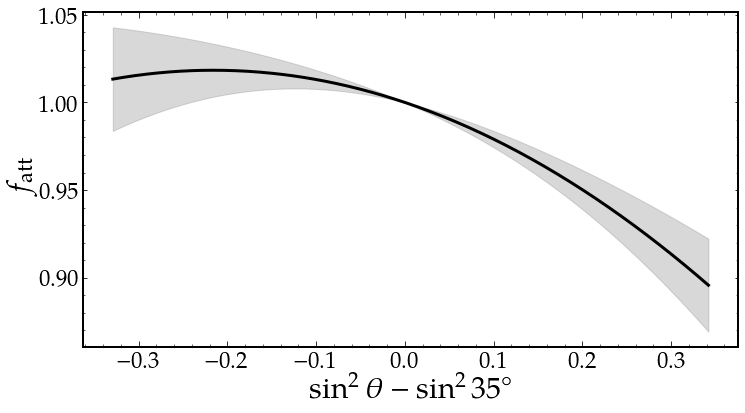

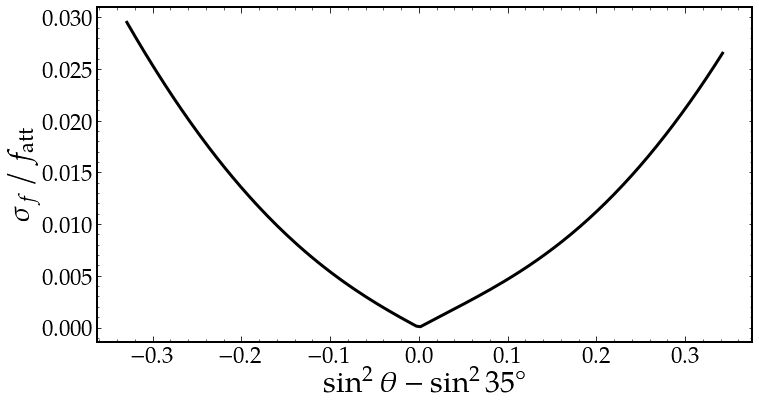

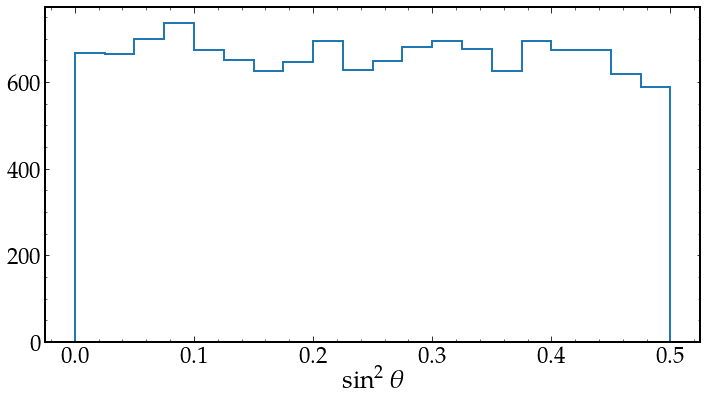

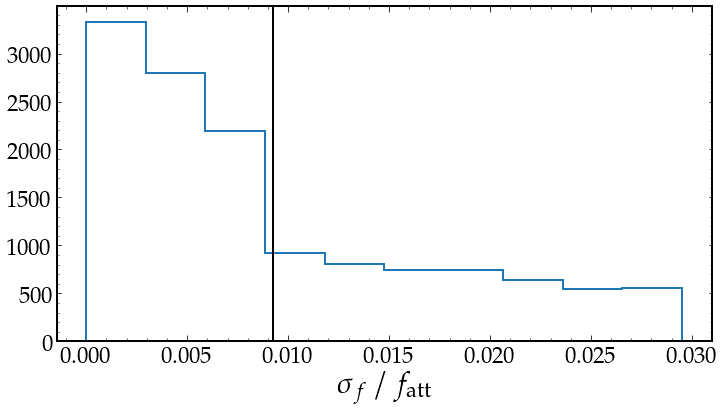

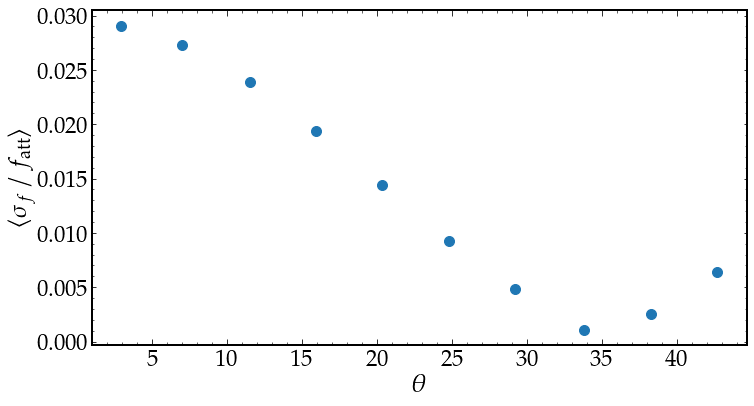

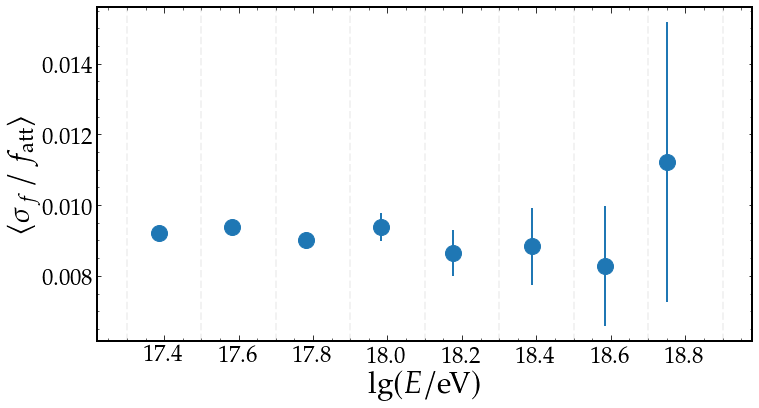

In [111]:
def f_att(theta):
    """
    theta (deg)
    """
    sin2 = np.sin(np.deg2rad(theta))**2
    sin2_ref = np.sin(np.deg2rad(35))**2
    x = sin2 - sin2_ref 
    
    a, b = -0.17, -0.394
    
    return 1 + a*x + b*x**2

def sigma_fatt(theta):
    """
    theta (deg)
    """
    sin2 = np.sin(np.deg2rad(theta))**2
    sin2_ref = np.sin(np.deg2rad(35))**2
    x = sin2 - sin2_ref 
    
    var_a = 0.0021
    var_b = 0.044
    cov_ab = -0.0018
    df_da = x 
    df_db = x**2
    
    var_f = df_da**2 * var_a + df_db**2 * var_b + 2*df_da*df_db*cov_ab
    return np.sqrt(var_f)

theta_plot = np.linspace(0, 55, 200)
x_plot = np.sin(np.deg2rad(theta_plot))**2 - np.sin(np.deg2rad(35))**2

f_att_plot = f_att(theta_plot)
sigma_f_plot = sigma_fatt(theta_plot)
rel_sigma_f_plot = sigma_f_plot / f_att_plot

## plot of fatt (and its 1sigma band) vs x
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

ax.plot(x_plot, f_att_plot, lw=3, color="k")
ax.fill_between(x=x_plot, y1=f_att_plot - sigma_f_plot, y2=f_att_plot + sigma_f_plot, color="grey",
                  alpha=0.3)
ax.set_xlabel(r"$\sin^2\theta - \sin^2 35^\circ$", fontsize=30)
ax.set_ylabel(r"$f_\text{att}$", fontsize=30)

## plot of relative error of fatt vs x
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

ax.plot(x_plot, sigma_f_plot, lw=3, color="k")  
ax.set_xlabel(r"$\sin^2\theta - \sin^2 35^\circ$", fontsize=30)
ax.set_ylabel(r"$\sigma_f \, / \, f_\text{att}$", fontsize=30)

figname = "relative_error_fatt.pdf"
fig.savefig(figname, bbox_inches="tight")

# sin2 distribution in data
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
theta = df_standard["theta"].to_numpy()
sin2_standard = np.sin(np.deg2rad(theta))**2

ax.hist(sin2_standard, bins=20, histtype="step", lw=2)
#ax.axvline(x=np.sin(np.deg2rad(45))**2, ls="--", color="k", label=r"$\theta_\text{max}$")
#ax.legend()
ax.set_xlabel(r"$\sin^2\theta$")

# histogram of fatt errors 
error_fatt = sigma_fatt(theta=theta)
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

ax.hist(error_fatt, histtype="step", lw=2)
ax.axvline(x=np.mean(error_fatt))
ax.set_xlabel(r"$\sigma_f \, / \, f_\text{att}$", fontsize=30)

# profile of sigma_fatt vs theta 
p_error_f = profile(theta, error_fatt)
p_error_f.doProfile(xmin=0, xmax=45, bins=10)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.errorbar(p_error_f.profilexmean, p_error_f.profiley,
           yerr=p_error_f.profileyerr, fmt="o")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\langle \sigma_f \, / \, f_\text{att} \rangle$")

# profile of sigma_fatt vs energy 
p_error_f = profile(df_standard["lge"].to_numpy(), error_fatt)
p_error_f.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.errorbar(p_error_f.profilexmean, p_error_f.profiley,
           yerr=p_error_f.profileyerr, fmt="o", ms=16)
ax.set_xlabel(r"$\lg(E / \text{eV})$", fontsize=30)
ax.set_ylabel(r"$\langle \sigma_f \, / \, f_\text{att} \rangle$", fontsize=30)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

figname = "relative_error_fatt_profile_energy.pdf"
fig.savefig(figname, bbox_inches="tight")

## Muon pattern

This systematic is estimated by running the reconstruction again but with a muon pattern of 111x (3 "1s") and 11111x (5 "1s").

In [3]:
indir = "./different_muon_patterns/"

# standard (4 1s)
df4 = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                 delim_whitespace=True)
df4 = df4[ df4["lge"] > 17.3 ]
print(f"events with 4 1s = {len(df4)}")

assert (df4["theta"].to_numpy() < 45).all()

# (3 1s)
df3 = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes3_md6t50.dat",
                 delim_whitespace=True)
df3 = df3[ df3["lge"] > 17.3 ]
print(f"events with 3 1s = {len(df3)}")

# (5 1s)
df5 = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes5_md6t50.dat",
                 delim_whitespace=True)
df5 = df5[ df5["lge"] > 17.3 ]
print(f"events with 5 1s = {len(df5)}")

# is expected that the datasets have different number of events (although the difference is not large)
# because of the condition of having 3 counters with at least one muon pattern requested for LDF fiting
# since the muon pattern definition changes, this condition changes

# number of saturated events with 4 1s: 486 (3.66%)
# number of saturated events with 3 1s: 530 (3.97%)
# number of saturated events with 5 1s: 453 (3.44%)

events with 4 1s = 13256
events with 3 1s = 13358
events with 5 1s = 13163


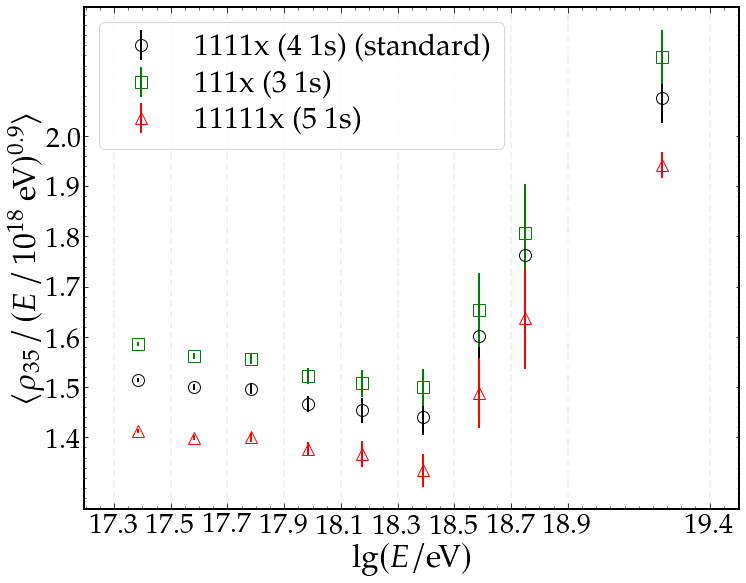

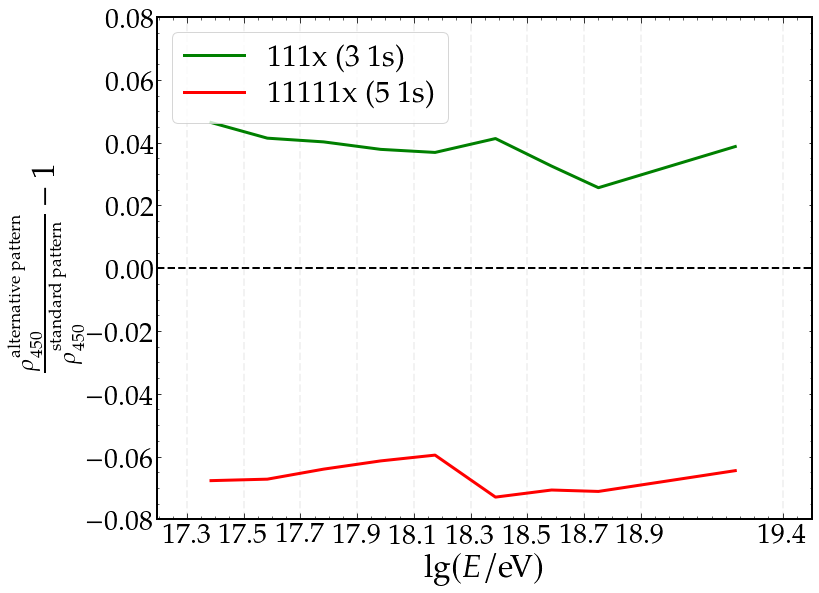

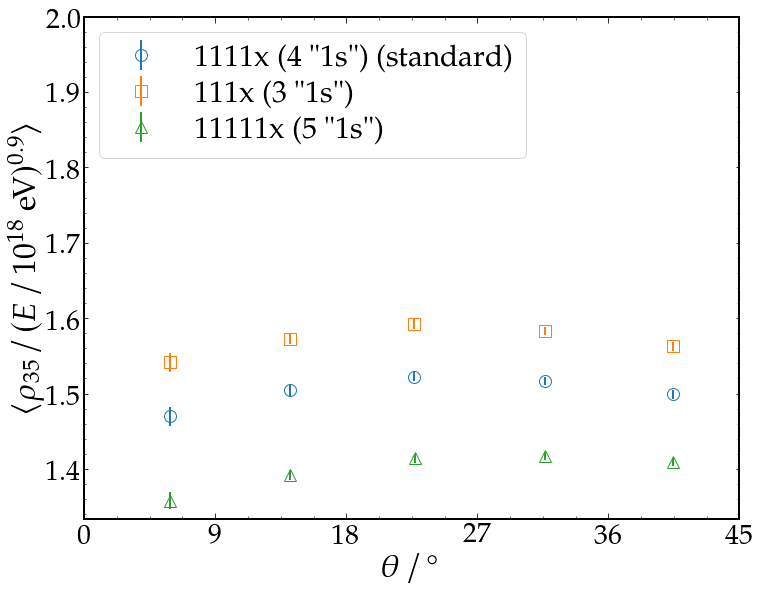

In [6]:
# edges of the energy binning for the profile
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.4]

color4 = "k"
color3 = "g"
color5 = "r"

# profile of rho35 / (E/10**18)**alpha vs energy
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_4 = ((10**df4["lge"].to_numpy()) / (10**(18)) )**alpha
rho_4_norm = df4["rho_att_corrected"].to_numpy() / norm_factor_4
p_norm_4 = profile(df4["lge"].to_numpy(), rho_4_norm)
p_norm_4.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)
#ax.errorbar(df4["lge"].to_numpy(), rho_4_norm, mfc="None", ms=2, alpha=0.5, fmt="o")

norm_factor_3 = ((10**df3["lge"].to_numpy()) / (10**(18)) )**alpha
rho_3_norm = df3["rho_att_corrected"].to_numpy() / norm_factor_3
p_norm_3 = profile(df3["lge"].to_numpy(), rho_3_norm)
p_norm_3.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_5 = ((10**df5["lge"].to_numpy()) / (10**(18)) )**alpha
rho_5_norm = df5["rho_att_corrected"].to_numpy() / norm_factor_5
p_norm_5 = profile(df5["lge"].to_numpy(), rho_5_norm)
p_norm_5.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax.errorbar(p_norm_4.profilexmean, p_norm_4.profiley, yerr=p_norm_4.profileyerr,
           fmt="o", label=r"1111x (4 1s) (standard)", mfc="None",
           ms=12, color=color4)

ax.errorbar(p_norm_3.profilexmean, p_norm_3.profiley, yerr=p_norm_3.profileyerr,
           fmt="s", label=r'111x (3 1s)', mfc="None", ms=12,
           color=color3)

ax.errorbar(p_norm_5.profilexmean, p_norm_5.profiley, yerr=p_norm_5.profileyerr,
           fmt="^", label=r"11111x (5 1s)", mfc="None", ms=12, color=color5)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(lge_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho35_norm_different_pattern.pdf"
fig.savefig(figname, bbox_inches="tight")

#######################
## ratio of profiles vs energy
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

ratio3 = np.array(p_norm_3.profiley) / np.array(p_norm_4.profiley)
ratio5 = np.array(p_norm_5.profiley) / np.array(p_norm_4.profiley)

ax.errorbar(p_norm_4.profilexmean, ratio3-1,
            label=r"111x (3 1s)", mfc="None", lw=3, color=color3)

ax.errorbar(p_norm_4.profilexmean, ratio5-1,
           label=r"11111x (5 1s)", mfc="None", lw=3, color=color5)

ax.axhline(y=0, ls="--", color="k")

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(r"$\frac{\rho_{450}^\text{alternative pattern}}{\rho_{450}^\text{standard pattern}} - 1$", 
              fontsize=32)

ax.set_xticks(lge_bin_edges)
ax.legend(fontsize=30, loc="upper left")
ax.set_ylim([-0.08, 0.08])

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho35_ratio_different_pattern.pdf"
fig.savefig(figname, bbox_inches="tight")

###############################################
# profile of rho35 / (E/10**18)**alpha vs theta
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))
theta_bin_edges = list(np.linspace(0, 45, 6))

p_norm_theta_4 = profile(df4["theta"].to_numpy(), rho_4_norm)
p_norm_theta_4.doProfile(xmin=min(theta_bin_edges), xmax=max(theta_bin_edges), bins=theta_bin_edges)

p_norm_theta_3 = profile(df3["theta"].to_numpy(), rho_3_norm)
p_norm_theta_3.doProfile(xmin=min(theta_bin_edges), xmax=max(theta_bin_edges), bins=theta_bin_edges)

p_norm_theta_5 = profile(df5["theta"].to_numpy(), rho_5_norm)
p_norm_theta_5.doProfile(xmin=min(theta_bin_edges), xmax=max(theta_bin_edges), bins=theta_bin_edges)


ax.errorbar(p_norm_theta_4.profilexmean, p_norm_theta_4.profiley, yerr=p_norm_theta_4.profileyerr,
           fmt="o", label=r'1111x (4 "1s") (standard)', mfc="None",
           ms=12)

ax.errorbar(p_norm_theta_3.profilexmean, p_norm_theta_3.profiley, yerr=p_norm_theta_3.profileyerr,
           fmt="s", label=r'111x (3 "1s")', mfc="None", ms=12)

ax.errorbar(p_norm_theta_5.profilexmean, p_norm_theta_5.profiley, yerr=p_norm_theta_5.profileyerr,
           fmt="^", label=r'11111x (5 "1s")', mfc="None", ms=12)

ax.set_xlabel(r"$\theta \, / \, ^\circ$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(theta_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)

## Seasonal or long-term variations

In [3]:
def get_gps_time_of_januarys():
    """
    get the gps time of january 1st of all years from 2018 to 2022 (phase 1)
    """
    
    gps_times = []
    years = [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
    # Define the date in UTC
    for year in years:
        utc_time = Time(f"{year}-01-01T00:00:00", scale="utc")

        # Convert to GPS time
        gps_time = utc_time.gps
        gps_times.append(gps_time)
    
    print(f"years = {years}")
    print(f"gps_times_january = {gps_times}")
    return gps_times

events = 13255
events phase 2 = 18040
Index(['event_id', 'yymmdd', 'gps_sec', 'lge', 'theta', 'rho450', 'rho450_err',
       'rho_att_corrected', 'rho_att_corrected_err'],
      dtype='object')
n events period 1 (up to 200727) = 4418
n events period 2 (200727 -- 210509)= 4417
n events period 3 (from 210509 to 211221) = 4418
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
gps_times_january = [1198800018.0, 1230336018.0, 1261872018.0, 1293494418.0, 1325030418.0, 1356566418.0, 1388102418.0, 1419724818.0]

aging_rate = (-0.0237 +- 0.0041) / year
relative_aging_rate = -1.6 % / year


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[]

['auger_182897338600__sd_50461323__md_2055'
 'auger_191682802400__sd_53933267__md_820']


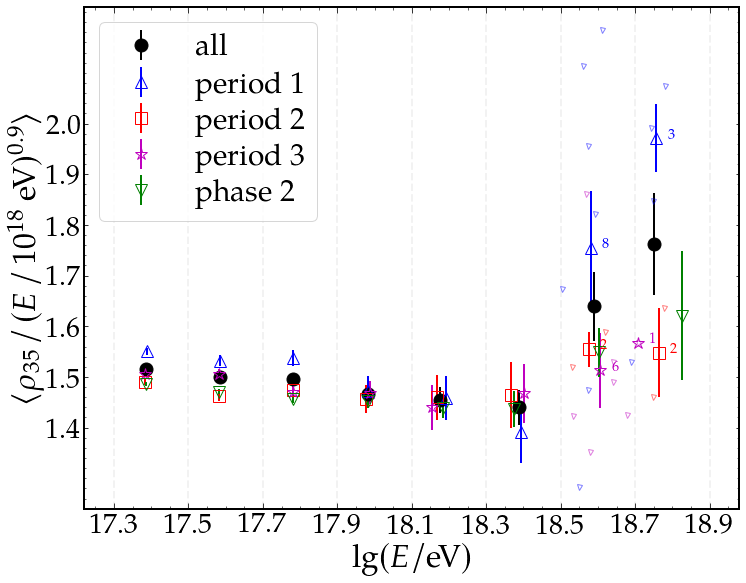

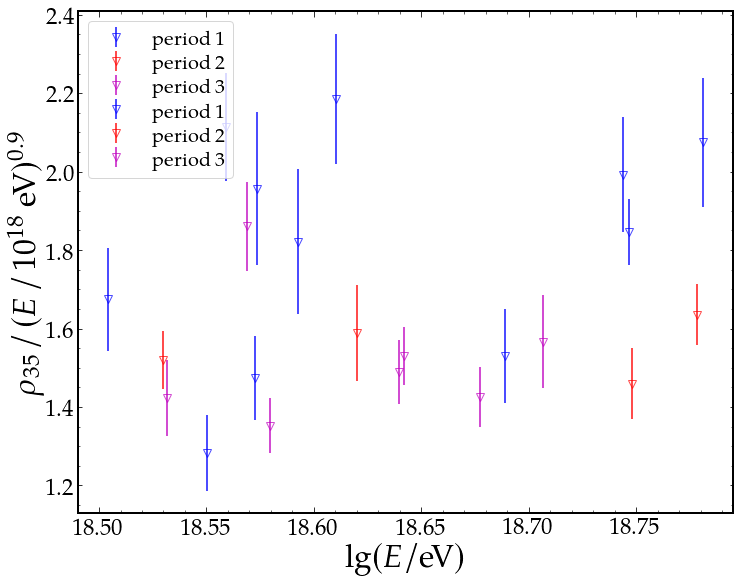

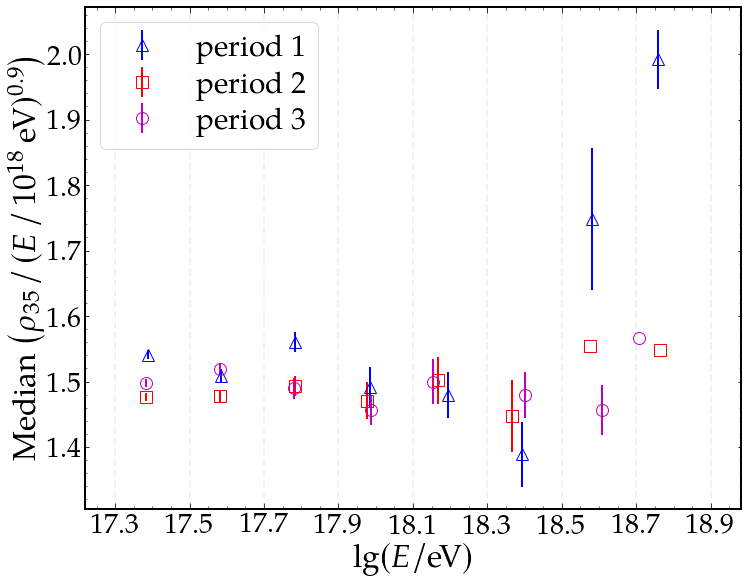

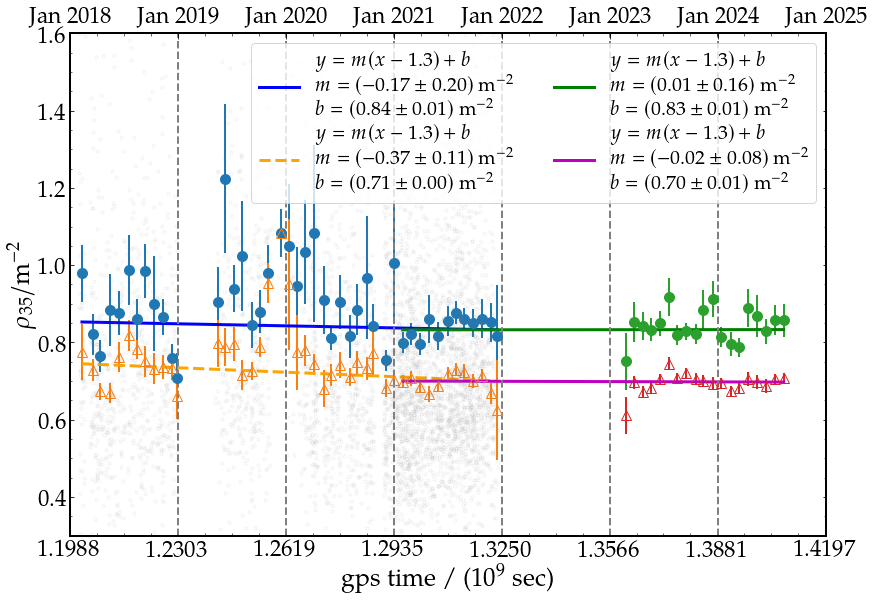

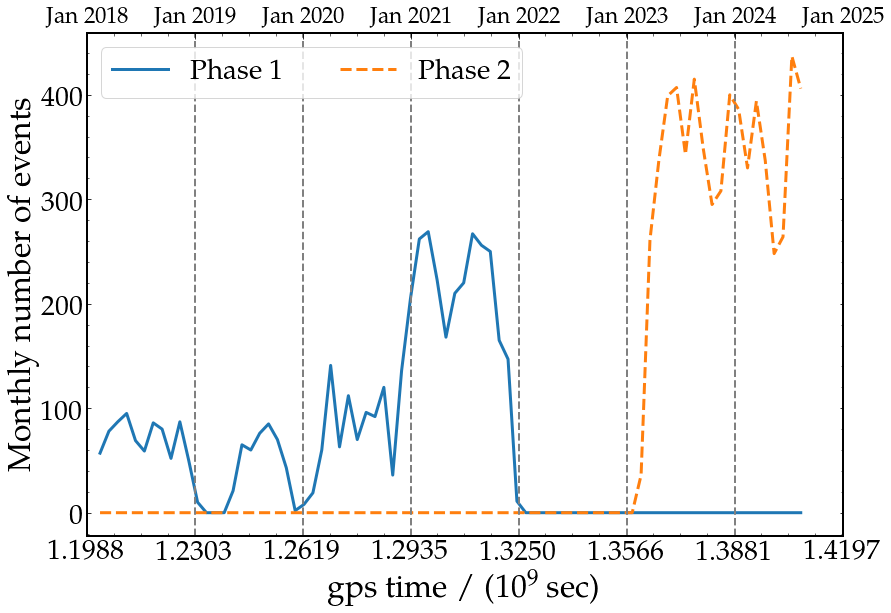

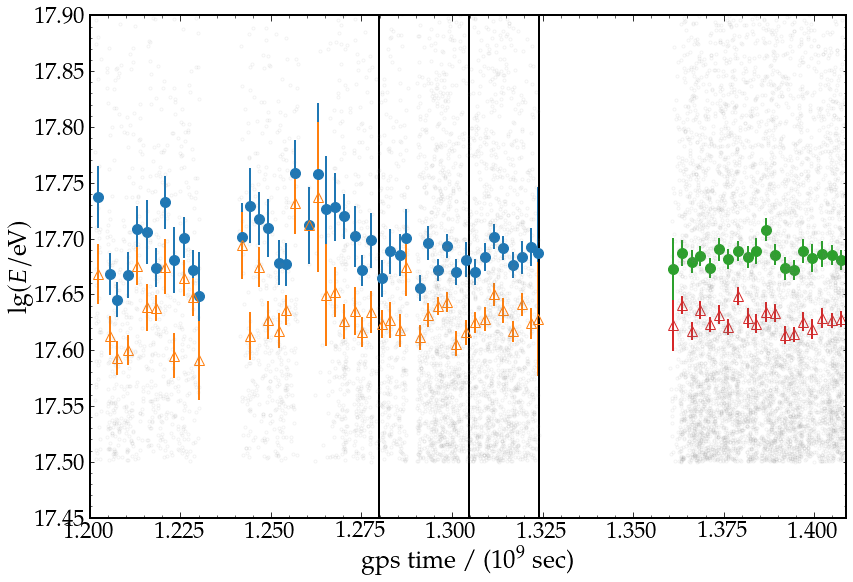

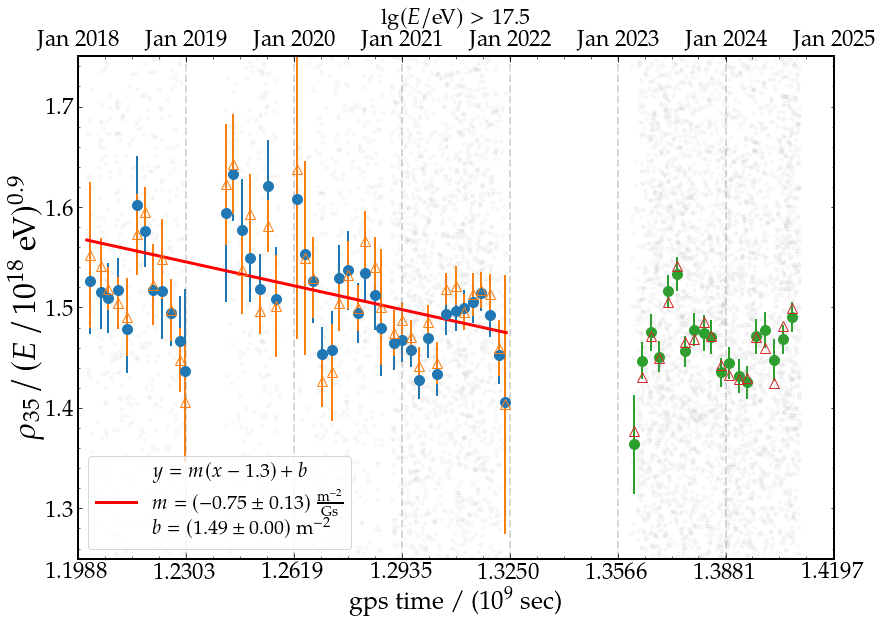

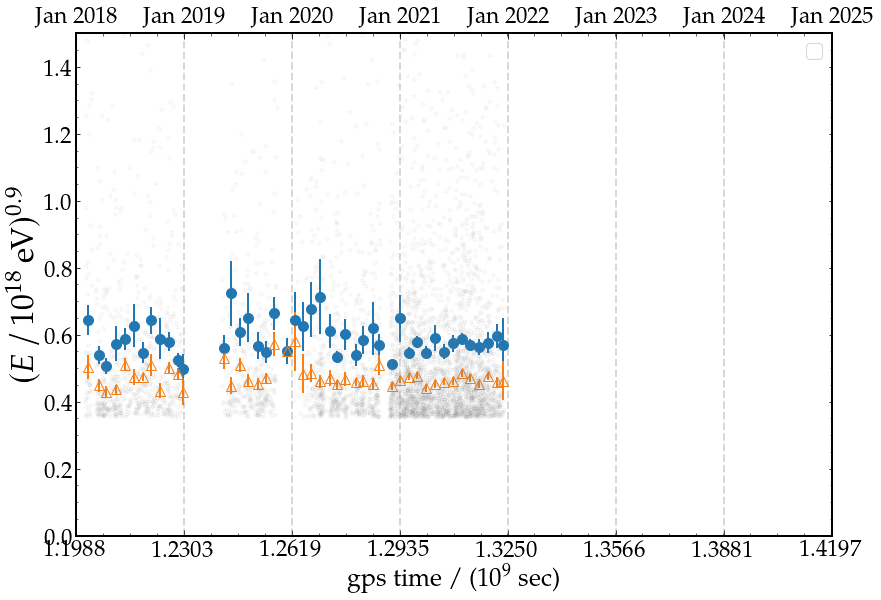

In [10]:
indir = "./different_reconstructions/"

color_all = "k"
color1 = "b"
color2 = "r"
color3 = "m"
color_phase2 = "g"

# standard (lt for long-term) (phase1)
df_lt = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                 delim_whitespace=True)
df_lt = df_lt[ df_lt["lge"] > 17.3 ]

# event 'auger_211666892900__sd_63786400__md_2656' is definetly biased, I take it out
df_lt = df_lt[ df_lt["event_id"] != 'auger_211666892900__sd_63786400__md_2656']
print(f"events = {len(df_lt)}")


# reading phase 2 results
df_phase2 = pd.read_csv(("./phase2/unbinned_dataset_fixBeta1_time0_like3"
                        "_fixCore0_useSil0_nOnes4_md6t50_phase2.dat"), 
                        delim_whitespace=True)
df_phase2 = df_phase2[ df_phase2["lge"] > 17.3 ]
print(f"events phase 2 = {len(df_phase2)}")

assert (df_lt["theta"].to_numpy() < 45).all()

print(df_lt.columns)

gps = df_lt["gps_sec"].to_numpy()
yymmdd = df_lt["yymmdd"].to_numpy()
rho_att_corrected_lt = df_lt["rho_att_corrected"].to_numpy()
lge_lt = df_lt["lge"].to_numpy()

### first dividing in three periods with the same number of events
q1 = np.quantile(gps, q=1/3)
q2 = np.quantile(gps, q=2/3)
q3 = max(gps)

# dates of quantiles 
idx1 = np.argmin(np.abs(q1-gps))
date1 = yymmdd[idx1]
idx2 = np.argmin(np.abs(q2-gps))
date2 = yymmdd[idx2]
idx3 = np.argmin(np.abs(q3-gps))
date3 = yymmdd[idx3]


df_period1 = df_lt[ df_lt["gps_sec"] < q1 ]
df_period2 = df_lt[ (q1 < df_lt["gps_sec"]) & (df_lt["gps_sec"] < q2) ]
df_period3 = df_lt[ df_lt["gps_sec"] > q2 ]

print(f"n events period 1 (up to {date1}) = {len(df_period1)}")
print(f"n events period 2 ({date1} -- {date2})= {len(df_period2)}")
print(f"n events period 3 (from {date2} to {date3}) = {len(df_period3)}")

# edges of the energy binning for the profile
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9]

# profile of rho35 / (E/10**18)**alpha vs energy
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

fig_high_energy, ax_he = plt.subplots(1, 1, figsize=(13, 9))

# all time period
norm_factor_all = ((10**lge_lt) / (10**(18)) )**alpha
rho_all_norm = rho_att_corrected_lt / norm_factor_all
p_norm_all = profile(lge_lt, rho_all_norm )
p_norm_all.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor1 = ((10**df_period1["lge"].to_numpy()) / (10**(18)) )**alpha
rho_1_norm = df_period1["rho_att_corrected"].to_numpy() / norm_factor1
p_norm1 = profile(df_period1["lge"].to_numpy(), rho_1_norm)
p_norm1.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor2 = ((10**df_period2["lge"].to_numpy()) / (10**(18)) )**alpha
rho_2_norm = df_period2["rho_att_corrected"].to_numpy() / norm_factor2
p_norm2 = profile(df_period2["lge"].to_numpy(), rho_2_norm)
p_norm2.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor3 = ((10**df_period3["lge"].to_numpy()) / (10**(18)) )**alpha
rho_3_norm = df_period3["rho_att_corrected"].to_numpy() / norm_factor3
p_norm3 = profile(df_period3["lge"].to_numpy(), rho_3_norm)
p_norm3.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# phase 2
norm_factor_phase2 = ((10**df_phase2["lge"].to_numpy()) / (10**(18)) )**alpha
rho_phase2_norm = df_phase2["rho_att_corrected"].to_numpy() / norm_factor_phase2 
p_norm_phase2 = profile(df_phase2["lge"].to_numpy(), rho_phase2_norm )
p_norm_phase2.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax.errorbar(p_norm_all.profilexmean, p_norm_all.profiley, yerr=p_norm_all.profileyerr,
           fmt="o", label=r"all", ms=13, color=color_all)

ax.errorbar(p_norm1.profilexmean, p_norm1.profiley, yerr=p_norm1.profileyerr,
           fmt="^", label=r"period 1", mfc="None", ms=12, color=color1)

ax.errorbar(p_norm2.profilexmean, p_norm2.profiley, yerr=p_norm2.profileyerr,
           fmt="s", label=r"period 2", mfc="None", ms=12, color=color2)

ax.errorbar(p_norm3.profilexmean, p_norm3.profiley, yerr=p_norm3.profileyerr,
           fmt="*", label=r"period 3", mfc="None", ms=12, color=color3)

ax.errorbar(p_norm_phase2.profilexmean, p_norm_phase2.profiley, 
            yerr=p_norm_phase2.profileyerr,
           fmt="v", label=r"phase 2", mfc="None", ms=12, color=color_phase2)


for i, edge in enumerate(lge_bin_edges):
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

last_bin_centers = sorted(p_norm_all.profilex[-2:])
#print(last_bin_centers)
for i, _ in enumerate(p_norm_all.profilex):
    # bin edges 
    lge1, lge2 = lge_bin_edges[i], lge_bin_edges[i+1]
    if i in [len(p_norm_all.profilex)-1, len(p_norm_all.profilex)-2]:
        # coordinates of text for period 1
        n1 = len(p_norm1.profileydistributions[i])
        x1 = p_norm1.profilexmean[i]
        y1 = p_norm1.profiley[i]
        
        ax.text(x1+0.03, y1, s=f"{n1}", color=color1, fontsize="x-large")
        # unbinned data of the period1 
        period1_bool = (lge1 < df_period1["lge"].to_numpy() ) & (df_period1["lge"].to_numpy() < lge2)
        ax.errorbar(df_period1["lge"].to_numpy()[period1_bool], rho_1_norm[period1_bool],
                   mfc="None", color=color1, ms=5, alpha=0.5, fmt="v")
        
        # only plotting unbinned data at the highest energies in a separate plot
        ax_he.errorbar(df_period1["lge"].to_numpy()[period1_bool], rho_1_norm[period1_bool], 
                       yerr=df_period1["rho_att_corrected_err"].to_numpy()[period1_bool] / norm_factor1[period1_bool],
                   mfc="None", color=color1, ms=8, alpha=0.7, fmt="v", label="period 1")
        
        # coordinates of text for period 2
        n2 = len(p_norm2.profileydistributions[i])
        x2 = p_norm2.profilexmean[i]
        y2 = p_norm2.profiley[i]
        
        ax.text(x2+0.03, y2, s=f"{n2}", color=color2, fontsize="x-large")
        # unbinned data of the period2
        period2_bool = (lge1 < df_period2["lge"].to_numpy() ) & (df_period2["lge"].to_numpy() < lge2)
        ax.errorbar(df_period2["lge"].to_numpy()[period2_bool], rho_2_norm[period2_bool], 
                   mfc="None", color=color2, ms=5, alpha=0.5, fmt="v")
        
        # only plotting unbinned data at the highest energies in a separate plot
        ax_he.errorbar(df_period2["lge"].to_numpy()[period2_bool], rho_2_norm[period2_bool], 
                       yerr=df_period2["rho_att_corrected_err"].to_numpy()[period2_bool] / norm_factor2[period2_bool],
                   mfc="None", color=color2, ms=8, alpha=0.7, fmt="v", label="period 2")
        
    
        # coordinates of text for period 3
        n3 = len(p_norm3.profileydistributions[i])
        x3 = p_norm3.profilexmean[i]
        y3 = p_norm3.profiley[i]
        
        # unbinned data of the period2
        period3_bool = (lge1 < df_period3["lge"].to_numpy() ) & (df_period3["lge"].to_numpy() < lge2)
        ax.errorbar(df_period3["lge"].to_numpy()[period3_bool], rho_3_norm[period3_bool],
                   mfc="None", color=color3, ms=5, alpha=0.5, fmt="v")
        
        # only plotting unbinned data at the highest energies in a separate plot
        ax_he.errorbar(df_period3["lge"].to_numpy()[period3_bool], rho_3_norm[period3_bool], 
                       yerr=df_period3["rho_att_corrected_err"].to_numpy()[period3_bool] / norm_factor3[period3_bool],
                   mfc="None", color=color3, ms=8, alpha=0.7, fmt="v", label="period 3")
        
        ax.text(x3+0.03, y3, s=f"{n3}", color=color3, fontsize="x-large")
    

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(lge_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)


ax_he.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax_he.set_ylabel(rf"$ \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}$",
             fontsize=32)
ax_he.legend()

### same but using the medians
figg, axx = plt.subplots(1, 1, figsize=(13, 9))
axx.errorbar(p_norm1.profilexmean, p_norm1.profileymedian, yerr=p_norm1.profileyiql,
           fmt="^", label=r"period 1", mfc="None", ms=12, color=color1)

axx.errorbar(p_norm2.profilexmean, p_norm2.profileymedian, yerr=p_norm2.profileyiql,
           fmt="s", label=r"period 2", mfc="None", ms=12, color=color2)

axx.errorbar(p_norm3.profilexmean, p_norm3.profileymedian, yerr=p_norm3.profileyiql,
           fmt="o", label=r"period 3", mfc="None", ms=12, color=color3)

for edge in lge_bin_edges:
    axx.axvline(x=edge, ls="--", color="grey", alpha=0.1)

axx.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
axx.set_ylabel(rf"$\text{{Median}}\left(\rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\right)$",
             fontsize=32)
axx.set_xticks(lge_bin_edges)
axx.set_yticks(np.arange(1.4, 2.001, step=0.1))
axx.legend(fontsize=30, loc="upper left")

axx.tick_params(axis='both', which='major', labelsize=28)

##############################################
########## TIME SERIES ####################
#############################################

januaries_gps = get_gps_time_of_januarys()


#################################################
### profile of mean rho35 vs gps time (time series)
seconds_hour = 3600
seconds_in_day = 24*seconds_hour 
step_gps = 30*seconds_in_day
step_gps_norm = step_gps / 10**9

# using events with an energy cut
lge_cut = 17.5

gps_phase2 = df_phase2["gps_sec"].to_numpy()
rho_att_corrected_phase2 = df_phase2["rho_att_corrected"].to_numpy()
lge_phase2 = df_phase2["lge"].to_numpy()

# normalizing by 10**9
gps_norm = gps / 10**9
gps_phase2_norm = gps_phase2 / 10**9

gps_bin_edges = np.arange(min(gps_norm), max(gps_phase2_norm), step=step_gps_norm)

pp = profile(x=gps_norm[lge_lt > lge_cut], y=rho_att_corrected_lt[lge_lt > lge_cut])
pp.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))

pp_phase2 = profile(x=gps_phase2_norm[lge_phase2 > lge_cut], 
                    y=rho_att_corrected_phase2[lge_phase2 > lge_cut])
pp_phase2.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))


fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.errorbar(pp.profilexmean, pp.profiley, yerr=pp.profileyerr, fmt="o")
ax.errorbar(pp.profilexmean, pp.profileymedian, yerr=pp.profileyiql, fmt="^", mfc="None")
ax.errorbar(gps_norm[lge_lt > lge_cut], rho_att_corrected_lt[lge_lt > lge_cut], fmt="o", mfc="None", ms=3, color="grey",
           alpha=0.1)

ax.errorbar(pp_phase2.profilexmean, pp_phase2.profiley, yerr=pp_phase2.profileyerr, fmt="o")
ax.errorbar(pp_phase2.profilexmean, pp_phase2.profileymedian, yerr=pp_phase2.profileyiql, fmt="^", mfc="None")

# fit linear function to see aging rate to phase1
xtofit = np.array(pp.profilexmean)
ytofit = np.array(pp.profiley)
ytofiterr = np.array(pp.profileyerr) 

# cleaning some points of the profile that are set to zero bc
# there are no events 
# fit mean
xtofit = xtofit[ytofiterr > 0]
ytofit = ytofit[ytofiterr > 0]
ytofiterr = ytofiterr[ytofiterr > 0]

x_ref_fit = 1.3
aging_fit = fit_linear(x=xtofit, y=ytofit, yerr=ytofiterr, 
           x_ref=x_ref_fit, p0=(1, 1))

label_fit = (rf"$y = m(x-{x_ref_fit:.1f}) + b$" "\n"
            rf"$m = \left({aging_fit['popt'][0]:.2f} \pm {aging_fit['popt_err'][0]:.2f}\right)$" r" $\text{m}^{-2}$" "\n"
            rf"$b = \left({aging_fit['popt'][1]:.2f} \pm {aging_fit['popt_err'][1]:.2f}\right)$" r" $\text{m}^{-2}$")

xplot = np.linspace(min(xtofit), 
                    max(xtofit), 500)
yplot = aging_fit["popt"][0]*(xplot-x_ref_fit) + aging_fit["popt"][1]

# plot fit 
ax.plot(xplot, yplot, lw=3, color="b", label=label_fit)


# fit median phase 1
xtofit = np.array(pp.profilexmean)
ytofit = np.array(pp.profileymedian)
ytofiterr = np.array(pp.profileyiql) 

xtofit = xtofit[ytofiterr > 0]
ytofit = ytofit[ytofiterr > 0]
ytofiterr = ytofiterr[ytofiterr > 0]

x_ref_fit = 1.3
aging_fit_median = fit_linear(x=xtofit, y=ytofit, yerr=ytofiterr, 
           x_ref=x_ref_fit, p0=(1, 1))

label_fit_median = (rf"$y = m(x-{x_ref_fit:.1f}) + b$" "\n"
            rf"$m = \left({aging_fit_median['popt'][0]:.2f} \pm {aging_fit_median['popt_err'][0]:.2f}\right)$" r" $\text{m}^{-2}$" "\n"
            rf"$b = \left({aging_fit_median['popt'][1]:.2f} \pm {aging_fit_median['popt_err'][1]:.2f}\right)$" r" $\text{m}^{-2}$")

xplot = np.linspace(min(xtofit), 
                    max(xtofit), 500)
yplot_median = aging_fit_median["popt"][0]*(xplot-x_ref_fit) + aging_fit_median["popt"][1]

# fit aging rate of the median
ax.plot(xplot, yplot_median, lw=3, color="orange", ls="--", label=label_fit_median)

# fit aging rate of the mean from January 2021 (phase 1 + phase2)
xtofit = np.array(pp.profilexmean + pp_phase2.profilexmean )
ytofit = np.array(pp.profiley + pp_phase2.profiley)
ytofiterr = np.array(pp.profileyerr + pp_phase2.profileyerr) 

# cleaning some points of the profile that are set to zero bc
# there are no events 
xtofit = xtofit[ytofiterr > 0]
ytofit = ytofit[ytofiterr > 0]
ytofiterr = ytofiterr[ytofiterr > 0]

## only doing the fit after Jan 2021
ytofit = ytofit[xtofit > 1.2936]
ytofiterr = ytofiterr[xtofit > 1.2936]
xtofit = xtofit[xtofit > 1.2936]

x_ref_fit = 1.3
aging_fit = fit_linear(x=xtofit, y=ytofit, yerr=ytofiterr, 
           x_ref=x_ref_fit, p0=(1, 1))

label_fit = (rf"$y = m(x-{x_ref_fit:.1f}) + b$" "\n"
            rf"$m = \left({aging_fit['popt'][0]:.2f} \pm {aging_fit['popt_err'][0]:.2f}\right)$" r" $\text{m}^{-2}$" "\n"
            rf"$b = \left({aging_fit['popt'][1]:.2f} \pm {aging_fit['popt_err'][1]:.2f}\right)$" r" $\text{m}^{-2}$")

xplot = np.linspace(min(xtofit), 
                    max(xtofit), 500)
yplot = aging_fit["popt"][0]*(xplot-x_ref_fit) + aging_fit["popt"][1]

# plot fit 
ax.plot(xplot, yplot, lw=3, color="g", label=label_fit)

#### same but with the median (phase1 + phase2)
# fit aging rate of the mean from January 2021 (phase 1 + phase2)
xtofit = np.array(pp.profilexmean + pp_phase2.profilexmean )
ytofit = np.array(pp.profileymedian + pp_phase2.profileymedian)
ytofiterr = np.array(pp.profileyiql + pp_phase2.profileyiql) 

# cleaning some points of the profile that are set to zero bc
# there are no events 
xtofit = xtofit[ytofiterr > 0]
ytofit = ytofit[ytofiterr > 0]
ytofiterr = ytofiterr[ytofiterr > 0]

## only doing the fit after Jan 2021
ytofit = ytofit[xtofit > 1.2936]
ytofiterr = ytofiterr[xtofit > 1.2936]
xtofit = xtofit[xtofit > 1.2936]

x_ref_fit = 1.3
aging_fit = fit_linear(x=xtofit, y=ytofit, yerr=ytofiterr, 
           x_ref=x_ref_fit, p0=(1, 1))

label_fit = (rf"$y = m(x-{x_ref_fit:.1f}) + b$" "\n"
            rf"$m = \left({aging_fit['popt'][0]:.2f} \pm {aging_fit['popt_err'][0]:.2f}\right)$" r" $\text{m}^{-2}$" "\n"
            rf"$b = \left({aging_fit['popt'][1]:.2f} \pm {aging_fit['popt_err'][1]:.2f}\right)$" r" $\text{m}^{-2}$")

xplot = np.linspace(min(xtofit), 
                    max(xtofit), 500)
yplot = aging_fit["popt"][0]*(xplot-x_ref_fit) + aging_fit["popt"][1]

# plot fit 
ax.plot(xplot, yplot, lw=3, color="m", label=label_fit)


for gg in januaries_gps:
    ax.axvline(gg/10**9, ls="--", color="grey")


ax.set_xlim(left=min(np.array(januaries_gps)/10**9), right=max(np.array(januaries_gps)/10**9))

ax.set_xticks(np.array(januaries_gps)/10**9)

# secondary axis with dates 
# Create a twin x-axis
axdates1 = ax.twiny()

# Adjust the second x-axis limits to match the first
axdates1.set_xlim(ax.get_xlim())

axdates1.set_xticks(np.array(januaries_gps)/10**9)
dates_labels = ["Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", 
               "Jan 2023", "Jan 2024", "Jan 2025"]
axdates1.set_xticklabels(dates_labels)

ax.legend(ncol=2)
    

ax.set_ylim([0.3, 1.6])
ax.set_xlabel(r"gps time / ($10^{9}$ sec)")
ax.set_ylabel(r"$\rho_{35} / \text{m}^{-2}$")


############################################
### Time series of monthly number of events
n_events_phase1 = [len(dist) for dist in pp.profileydistributions]
n_events_phase2 = [len(dist) for dist in pp_phase2.profileydistributions] 

fign, axn = plt.subplots(1, 1, figsize=(15, 9))

axn.plot(pp.profilex, n_events_phase1, lw=3, label="Phase 1")
axn.plot(pp_phase2.profilex, n_events_phase2, lw=3, ls="--",
         label="Phase 2")

for gg in januaries_gps:
    axn.axvline(gg/10**9, ls="--", color="grey")


axn.set_xlim(left=min(np.array(januaries_gps)/10**9), 
             right=max(np.array(januaries_gps)/10**9))

axn.set_xticks(np.array(januaries_gps)/10**9)

# secondary axis with dates 
# Create a twin x-axis
axdatesn = axn.twiny()

# Adjust the second x-axis limits to match the first
axdatesn.set_xlim(axn.get_xlim())

axdatesn.set_xticks(np.array(januaries_gps)/10**9)
dates_labels = ["Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", 
               "Jan 2023", "Jan 2024", "Jan 2025"]
axdatesn.set_xticklabels(dates_labels)

axn.tick_params(axis='both', which='major', labelsize=28)

axn.legend(ncol=2, fontsize=28)

axn.set_xlabel(r"gps time / ($10^{9}$ sec)", fontsize=32)
axn.set_ylabel(r"Monthly number of events", fontsize=32)

fign.savefig("events_vs_time_phases.pdf", bbox_inches="tight")

#############################
#############################
#### mean energy vs gps time

pp_lge = profile(x=gps_norm[lge_lt > lge_cut], y=lge_lt[lge_lt > lge_cut])
pp_lge.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))

# phase 2
pp_lge_phase2 = profile(x=gps_phase2_norm[lge_phase2 > lge_cut], 
                        y=lge_phase2[lge_phase2 > lge_cut])
pp_lge_phase2.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))

fig2, ax2 = plt.subplots(1, 1, figsize=(15, 9))
ax2.errorbar(pp_lge.profilexmean, pp_lge.profiley, yerr=pp_lge.profileyerr, fmt="o")
ax2.errorbar(pp_lge.profilexmean, pp_lge.profileymedian, yerr=pp_lge.profileyiql, fmt="^", mfc="None")
ax2.errorbar(gps_norm[lge_lt > lge_cut], lge_lt[lge_lt > lge_cut], fmt="o", mfc="None", ms=3, color="grey",
           alpha=0.1)

ax2.errorbar(pp_lge_phase2.profilexmean, pp_lge_phase2.profiley, 
             yerr=pp_lge_phase2.profileyerr, fmt="o")
ax2.errorbar(pp_lge_phase2.profilexmean, pp_lge_phase2.profileymedian, 
             yerr=pp_lge_phase2.profileyiql, fmt="^", mfc="None")
ax2.errorbar(gps_phase2_norm[lge_phase2 > lge_cut], 
             lge_phase2[lge_phase2 > lge_cut], fmt="o", 
             mfc="None", ms=3, color="grey",
           alpha=0.1)


ax2.axvline(x=q1/10**9)
ax2.axvline(x=q2/10**9)
ax2.axvline(x=q3/10**9)

ax2.set_xlim(left=sorted(pp_lge.profilexmean)[2]-0.5)
ax2.set_ylim([17.45, 17.9])
ax2.set_xlim(left=1.2, right=max(gps_bin_edges))
ax2.set_xlabel(r"gps time / ($10^{9}$ sec)")
ax2.set_ylabel(r"$\lg(E/\text{eV})$")

##########################
## normalized rho vs gps
p__ = profile(x=gps_norm[lge_lt > lge_cut], y=rho_all_norm[lge_lt > lge_cut])
p__.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))
# phase 2
p__phase2 = profile(x=gps_phase2_norm[lge_phase2 > lge_cut], 
                    y=rho_phase2_norm[lge_phase2 > lge_cut])
p__phase2.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))

# fit linear function to see aging rate
xtofit = np.array(p__.profilexmean)
ytofit = np.array(p__.profiley)
ytofiterr = np.array(p__.profileyerr)

# cleaning some points of the profile that are set to zero bc
# there are no events 
xtofit = xtofit[ytofiterr > 0]
ytofit = ytofit[ytofiterr > 0]
ytofiterr = ytofiterr[ytofiterr > 0]

x_ref_fit = 1.3
aging_fit = fit_linear(x=xtofit, y=ytofit, yerr=ytofiterr, 
           x_ref=x_ref_fit, p0=(1, 1))

# express the aging rate in years
giga_seconds_in_year = 3600*24*365 / 10**9
yr = 1 / giga_seconds_in_year # year expressed in gigaseconds

# aging rate in m-2 / yr
aging_rate = aging_fit['popt'][0] / yr
aging_rate_err = aging_fit['popt_err'][0] / yr
relative_aging_rate = aging_rate / aging_fit['popt'][1]
print("")
print(f"aging_rate = ({aging_rate:.4f} +- {aging_rate_err:.4f}) / year")
print(f"relative_aging_rate = {relative_aging_rate*100:.1f} % / year")

label_fit = (rf"$y = m(x-{x_ref_fit:.1f}) + b$" "\n"
            rf"$m = \left({aging_fit['popt'][0]:.2f} \pm {aging_fit['popt_err'][0]:.2f}\right)$" r" $\frac{\text{m}^{-2}}{\text{Gs}}$" "\n"
            rf"$b = \left({aging_fit['popt'][1]:.2f} \pm {aging_fit['popt_err'][1]:.2f}\right)$" r" $\text{m}^{-2}$")

xplot = np.linspace(min(gps_norm[lge_lt > lge_cut]), 
                    max(gps_norm[lge_lt > lge_cut]), 500)
yplot = aging_fit["popt"][0]*(xplot-x_ref_fit) + aging_fit["popt"][1]

fig3, ax3 = plt.subplots(1, 1, figsize=(15, 9))
ax3.set_title(rf"$\lg(E/\text{{eV}}) > {lge_cut:.1f}$")
ax3.errorbar(p__.profilexmean, p__.profiley, yerr=p__.profileyerr, fmt="o")
ax3.errorbar(p__.profilexmean, p__.profileymedian, yerr=pp.profileyiql, fmt="^", mfc="None")
ax3.errorbar(gps_norm[lge_lt > lge_cut], rho_all_norm[lge_lt > lge_cut], fmt="o", mfc="None", ms=3, color="grey",
           alpha=0.1)

ax3.errorbar(p__phase2.profilexmean, p__phase2.profiley, 
             yerr=p__phase2.profileyerr, fmt="o")
ax3.errorbar(p__phase2.profilexmean, p__phase2.profileymedian, 
             yerr=pp.profileyiql, fmt="^", mfc="None")
ax3.errorbar(gps_phase2_norm[lge_phase2 > lge_cut], 
             rho_phase2_norm[lge_phase2 > lge_cut], fmt="o", 
             mfc="None", ms=3, color="grey",
           alpha=0.1)

# fit aging rate
ax3.plot(xplot, yplot, lw=3, color="r", label=label_fit)

ax3.set_xlim(left=1.2, right=max(gps_norm))
ax3.set_ylabel(rf"$\rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}$",
             fontsize=32)
ax3.set_xlabel(r"gps time / ($10^{9}$ sec)")
ax3.set_ylim([1.25, 1.75])

for jj in januaries_gps:
    ax3.axvline(jj/10**9, ls="--", color="grey", alpha=0.3)

ax3.set_xticks(np.array(januaries_gps)/10**9)
    
# secondary axis with dates 
# Create a twin x-axis
axdates = ax3.twiny()

# Adjust the second x-axis limits to match the first
axdates.set_xlim(ax3.get_xlim())

axdates.set_xticks(np.array(januaries_gps)/10**9)
dates_labels = ["Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", 
               "Jan 2023", "Jan 2024", "Jan 2025"]
axdates.set_xticklabels(dates_labels)

ax3.legend()


#####################
### Time series of the normalization factor (E/10**18)**alpha
norm_factor_all = ((10**lge_lt) / (10**(18)) )**alpha
p_norm_factor = profile(gps_norm[lge_lt > lge_cut], norm_factor_all[lge_lt > lge_cut])
p_norm_factor.doProfile(xmin=min(gps_bin_edges), xmax=max(gps_bin_edges), 
             bins=list(gps_bin_edges))

fig4, ax4 = plt.subplots(1, 1, figsize=(15, 9))
ax4.errorbar(p_norm_factor.profilexmean, p_norm_factor.profiley, 
             yerr=p_norm_factor.profileyerr, fmt="o")
ax4.errorbar(p_norm_factor.profilexmean, p_norm_factor.profileymedian, 
             yerr=p_norm_factor.profileyiql, fmt="^", mfc="None")
ax4.errorbar(gps_norm[lge_lt > lge_cut], norm_factor_all[lge_lt > lge_cut], 
             fmt="o", mfc="None", ms=3, color="grey",
           alpha=0.1)

ax4.set_ylabel(rf"$(E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}$",
             fontsize=32)
ax4.set_xlabel(r"gps time / ($10^{9}$ sec)")

ax4.set_xlim(left=1.2, right=max(gps_norm))
#ax4.set_ylim([1.25, 1.75])
ax4.set_ylim([0, 1.5])

for jj in januaries_gps:
    ax4.axvline(jj/10**9, ls="--", color="grey", alpha=0.3)

ax4.set_xticks(np.array(januaries_gps)/10**9)
    
# secondary axis with dates 
# Create a twin x-axis
axdates4 = ax4.twiny()

# Adjust the second x-axis limits to match the first
axdates4.set_xlim(ax4.get_xlim())

axdates4.set_xticks(np.array(januaries_gps)/10**9)
dates_labels = ["Jan 2018", "Jan 2019", "Jan 2020", "Jan 2021", "Jan 2022", 
               "Jan 2023", "Jan 2024", "Jan 2025"]
axdates4.set_xticklabels(dates_labels)

ax4.legend()

## just printing two suspicious events
print("")
print(df_lt["event_id"].to_numpy()[(lge_lt>18.5) &  (lge_lt<18.7) & (rho_all_norm < 1.1)])
print("")

print(df_lt["event_id"].to_numpy()[(lge_lt>18.5) & (lge_lt<18.7) & (rho_all_norm > 2.1)])

median gps = 1295698963.0
UTC Time: 2021-01-26 12:22:25.000
Year: 2021, Month: 1, Day: 26
max gps UTC time = 2021-12-21 11:34:05.000
n events early = 6627
n events late = 6627


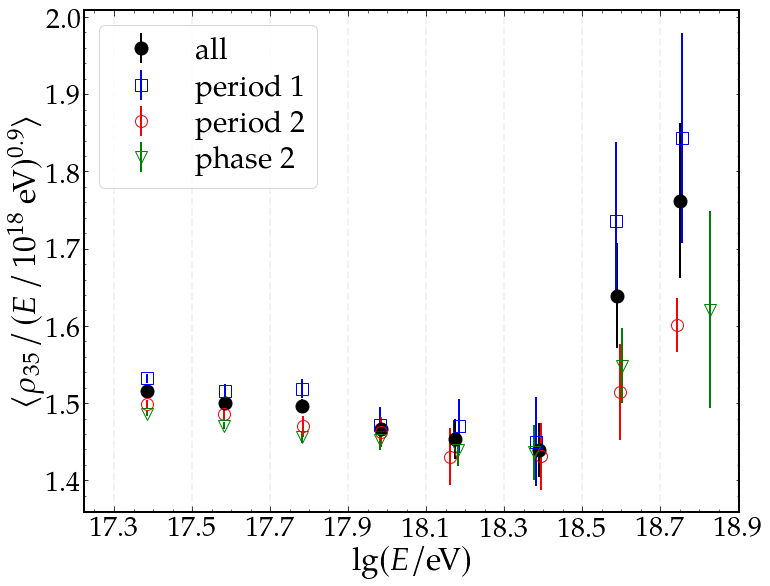

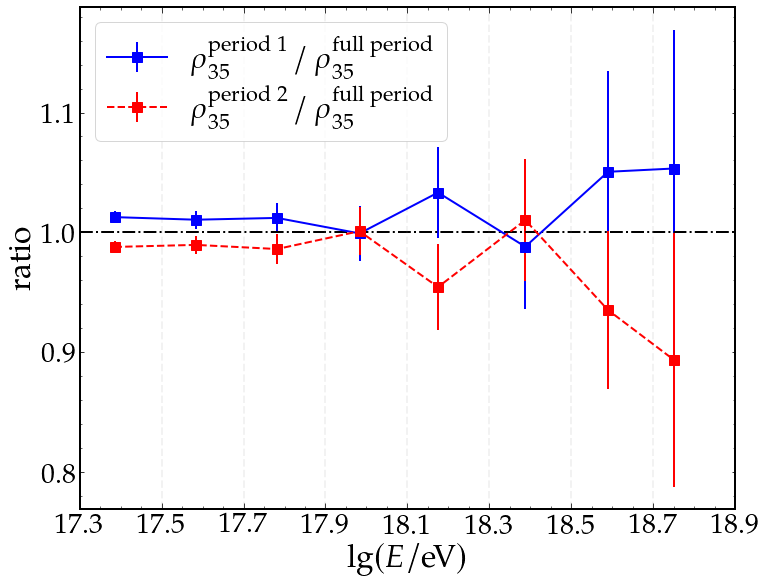

In [4]:
## now I divide in halves, ie, two periods with the same number of events each.
median_gps = np.median(gps)
median_utc_time = Time(median_gps, format="gps", scale="utc")

max_gps_utc_time = Time(max(gps), format="gps", scale="utc")

color_early = "b"
color_late = "r"

# Print results
print(f"median gps = {median_gps}")
print(f"UTC Time: {median_utc_time.iso}")  # ISO format
print(f"Year: {median_utc_time.datetime.year}, Month: {median_utc_time.datetime.month}, Day: {median_utc_time.datetime.day}")
print(f"max gps UTC time = {max_gps_utc_time.iso}")

df_early = df_lt[ df_lt["gps_sec"] < median_gps]
df_late = df_lt[ df_lt["gps_sec"] > median_gps]

print(f"n events early = {len(df_early)}")
print(f"n events late = {len(df_late)}")

# profile of rho35 vs energy
p35_full = profile(df_lt["lge"].to_numpy(), df_lt["rho_att_corrected"].to_numpy())
p35_full.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p35_early = profile(df_early["lge"].to_numpy(), df_early["rho_att_corrected"].to_numpy())
p35_early.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p35_late = profile(df_late["lge"].to_numpy(), df_late["rho_att_corrected"].to_numpy())
p35_late.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)



# profile of rho35 / (E/10**18)**alpha vs energy
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_early = ((10**df_early["lge"].to_numpy()) / (10**(18)) )**alpha
rho_early_norm = df_early["rho_att_corrected"].to_numpy() / norm_factor_early
p_norm_early = profile(df_early["lge"].to_numpy(), rho_early_norm)
p_norm_early.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_late = ((10**df_late["lge"].to_numpy()) / (10**(18)) )**alpha
rho_late_norm = df_late["rho_att_corrected"].to_numpy() / norm_factor_late
p_norm_late = profile(df_late["lge"].to_numpy(), rho_late_norm)
p_norm_late.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)


ax.errorbar(p_norm_all.profilexmean, p_norm_all.profiley, yerr=p_norm_all.profileyerr,
           fmt="o", label=r"all", ms=13, color=color_all)

ax.errorbar(p_norm_early.profilexmean, p_norm_early.profiley, yerr=p_norm_early.profileyerr,
           fmt="s", label=r"period 1", mfc="None", ms=12, color=color_early)

ax.errorbar(p_norm_late.profilexmean, p_norm_late.profiley, yerr=p_norm_late.profileyerr,
           fmt="o", label=r"period 2", mfc="None", ms=12, color=color_late)

ax.errorbar(p_norm_phase2.profilexmean, p_norm_phase2.profiley, 
            yerr=p_norm_phase2.profileyerr,
           fmt="v", label=r"phase 2", mfc="None", ms=12, color=color_phase2)

for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(lge_bin_edges)
ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)

figname = "rho_norm_sys_long_term.pdf"
fig.savefig(figname, bbox_inches="tight")

## ratio of normalized profiles
#ratio_early = np.array(p_norm_early.profiley) / np.array(p_norm_all.profiley)
#ratio_late = np.array(p_norm_late.profiley) / np.array(p_norm_all.profiley)

#ratio_early_err = ratio_early *  np.sqrt((np.array(p_norm_early.profileyerr)/np.array(p_norm_early.profiley))**2 + 
                         #(np.array(p_norm_all.profileyerr)/np.array(p_norm_all.profiley))**2 )

#ratio_late_err = ratio_late *  np.sqrt((np.array(p_norm_late.profileyerr)/np.array(p_norm_late.profiley))**2 + 
                         #(np.array(p_norm_all.profileyerr)/np.array(p_norm_all.profiley))**2 )

## ratio of unnormalized profiles
ratio_early = np.array(p35_early.profiley) / np.array(p35_full.profiley)
ratio_late = np.array(p35_late.profiley) / np.array(p35_full.profiley)

ratio_early_err = ratio_early *  np.sqrt((np.array(p35_early.profileyerr)/np.array(p35_early.profiley))**2 + 
                         (np.array(p35_full.profileyerr)/np.array(p35_full.profiley))**2 )

ratio_late_err = ratio_late *  np.sqrt((np.array(p35_late.profileyerr)/np.array(p35_late.profiley))**2 + 
                         (np.array(p35_full.profileyerr)/np.array(p35_full.profiley))**2 )


fig2, ax2 = plt.subplots(1, 1, figsize=(13, 9))

ax2.errorbar(p_norm_all.profilexmean, ratio_early, yerr=ratio_early_err,
             fmt="-s", lw=2, color=color_early, label=r"$\rho_{35}^\text{period 1} \, / \, \rho_{35}^\text{full period}$")
ax2.errorbar(p_norm_all.profilexmean, ratio_late, yerr= ratio_late_err,
             fmt="--s", lw=2, color=color_late, label=r"$\rho_{35}^\text{period 2} \, / \, \rho_{35}^\text{full period}$")

ax2.axhline(y=1, ls="-.", color="k")
ax2.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax2.set_ylabel("ratio",
             fontsize=32)
ax2.set_xticks(lge_bin_edges)
#ax.set_yticks(np.arange(1.4, 2.001, step=0.1))
ax2.legend(fontsize=30, loc="upper left")
for edge in lge_bin_edges:
    ax2.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax2.tick_params(axis='both', which='major', labelsize=28)

figname2 = "rho_ratio_long_term.pdf"
fig2.savefig(figname2, bbox_inches="tight")


## Uniformity through the array

Here I check the differences in the end result by diving the dataset in showers hitting the eastern/western part of the array and southern/northern. I use Phase 2 for this since it has larger statistics with more detectors deployed. 

***  phase 2  ****

events phase 2 = 18040
 events phase 2 (east) = 7628
 events phase 2 (west) = 10412

 events phase 2 (south) = 8865
 events phase 2 (north) = 8865


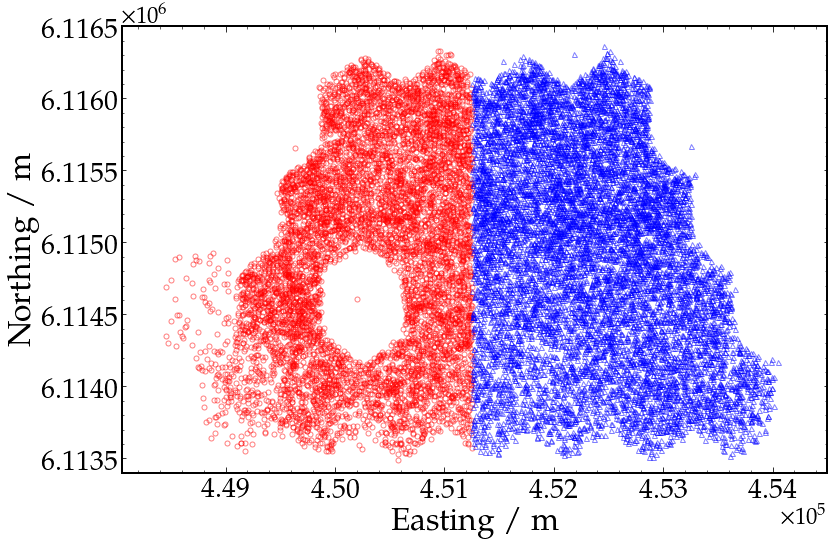

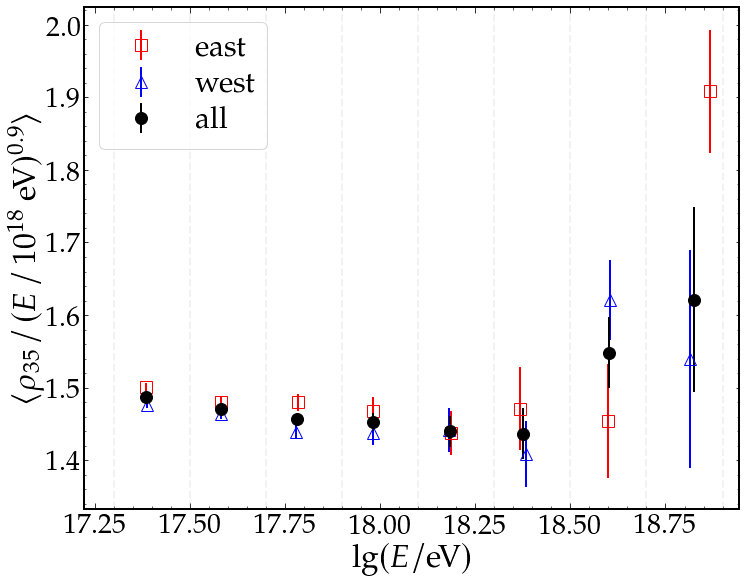

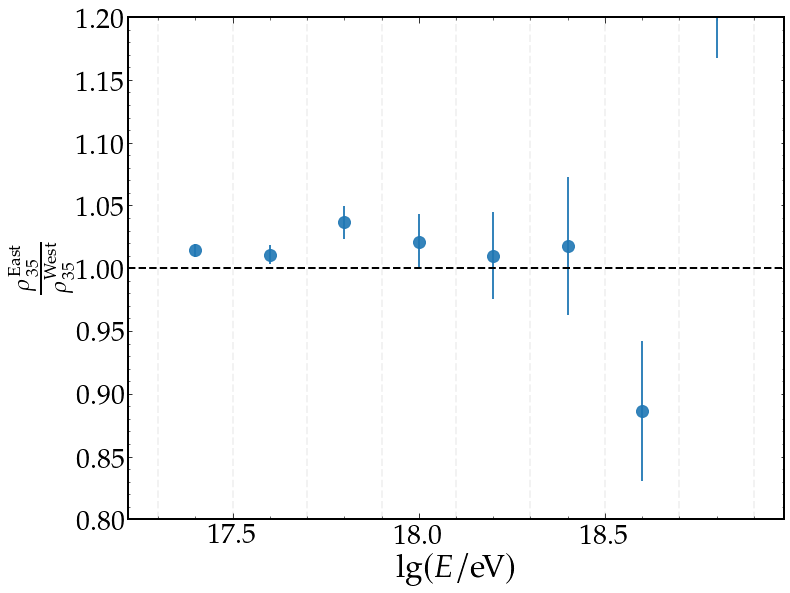

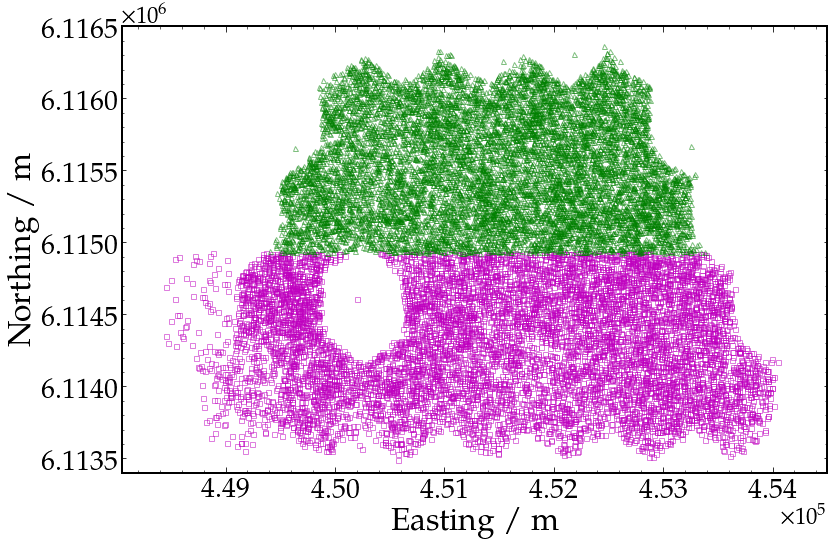

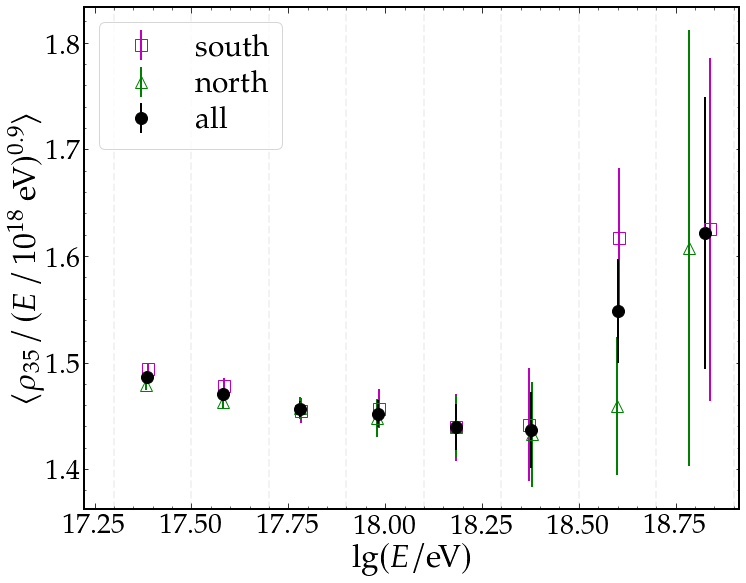

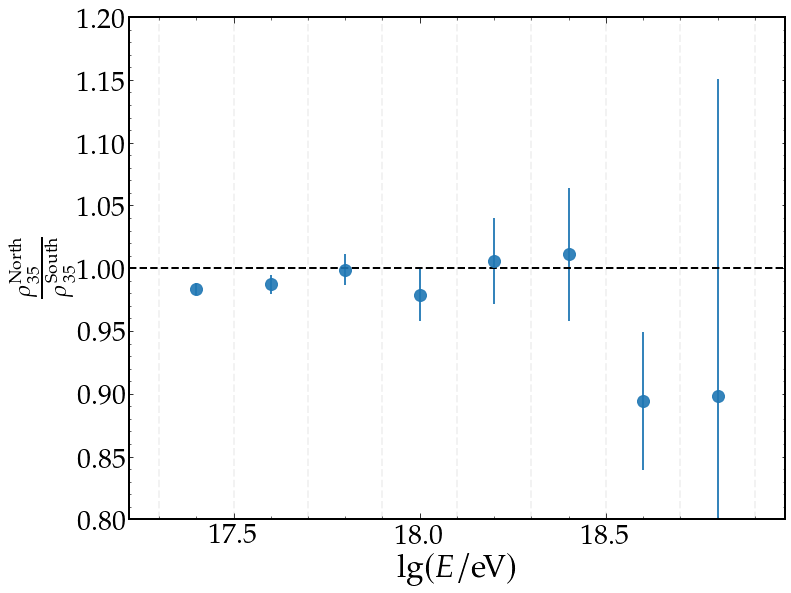

In [28]:
# define pahse
phase = 2

if phase not in [1, 2]:
    raise ValueError("phase should be 1 or 2")

print(f"***  phase {phase}  ****")
print("")    
if phase == 1:
    #reading phase 1 results
    df_phase = pd.read_csv(("./different_reconstructions/unbinned_dataset_fixBeta1_time0_like3"
                            "_fixCore0_useSil0_nOnes4_md6t50_phase1.dat"), 
                            delim_whitespace=True)
    df_phase = df_phase[ df_phase["lge"] > 17.3 ]
else:
    #reading phase 2 results
    df_phase = pd.read_csv(("./phase2/unbinned_dataset_fixBeta1_time0_like3"
                            "_fixCore0_useSil0_nOnes4_md6t50_phase2.dat"), 
                            delim_whitespace=True)
    df_phase = df_phase[ df_phase["lge"] > 17.3 ]
    
    
print(f"events phase {phase} = {len(df_phase)}")

color_east = "r"
color_west = "b"
color_north = "g"
color_south = "m"
# limits to plot the scatter plot of cores
y1, y2 = 6.1134e6, 6.1165e6
x1, x2 = 4.4805e5, 4.545e5 

"""
EAST -- WEST study
"""
# dividing coordinate of east/west
x_division = (max(df_phase["x_core"].to_numpy()) + min(df_phase["x_core"].to_numpy())) / 2

df_west = df_phase[ df_phase["x_core"] < x_division ]
df_east = df_phase[ df_phase["x_core"] >= x_division ]

print(f" events phase {phase} (east) = {len(df_east)}")
print(f" events phase {phase} (west) = {len(df_west)}")

### scatter plot of cores east/west
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.errorbar(df_east["x_core"], df_east["y_core"], color=color_east, mfc="None", ms=5,
           alpha=0.5, label="east", fmt="o")
ax.errorbar(df_west["x_core"], df_west["y_core"], color=color_west, mfc="None", ms=5,
           alpha=0.5, label="west", fmt="^")

ax.set_xlim([x1, x2])
ax.set_ylim([y1, y2])

ax.tick_params(axis='both', which='major', labelsize=28)
ax.set_xlabel(r"Easting / m", fontsize=32)
ax.set_ylabel(rf"Northing / m",
             fontsize=32)

figname = f"cores_east_west_phase{phase}.pdf"
fig.savefig(figname, bbox_inches="tight")

# edges of the energy binning for the profile
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9]

alpha = 0.9

# profile through all the array
norm_factor_array = ((10**df_phase["lge"].to_numpy()) / (10**(18)) )**alpha
rho_array_norm = df_phase["rho_att_corrected"].to_numpy() / norm_factor_array
p_norm_array = profile(df_phase["lge"].to_numpy(), rho_array_norm)
p_norm_array.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

###############
# profile of rho35 / (E/10**18)**alpha vs energy for east and west
fig2, ax2 = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_east = ((10**df_east["lge"].to_numpy()) / (10**(18)) )**alpha
rho_east_norm = df_east["rho_att_corrected"].to_numpy() / norm_factor_east
p_norm_east = profile(df_east["lge"].to_numpy(), rho_east_norm)
p_norm_east.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_west = ((10**df_west["lge"].to_numpy()) / (10**(18)) )**alpha
rho_west_norm = df_west["rho_att_corrected"].to_numpy() / norm_factor_west
p_norm_west = profile(df_west["lge"].to_numpy(), rho_west_norm)
p_norm_west.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax2.errorbar(p_norm_east.profilexmean, p_norm_east.profiley, yerr=p_norm_east.profileyerr,
           fmt="s", label=r"east", mfc="None", ms=12, color=color_east)

ax2.errorbar(p_norm_west.profilexmean, p_norm_west.profiley, yerr=p_norm_west.profileyerr,
           fmt="^", label=r"west", mfc="None", ms=12, color=color_west)

ax2.errorbar(p_norm_array.profilexmean, p_norm_array.profiley, 
             yerr=p_norm_array.profileyerr,
           fmt="o", label=r"all", ms=12, color="k")

ax2.legend(fontsize=30, loc="upper left")
for edge in lge_bin_edges:
    ax2.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax2.tick_params(axis='both', which='major', labelsize=28)
ax2.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax2.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)

figname2 = f"rho_norm_east_west_phase{phase}.pdf"
fig2.savefig(figname2, bbox_inches="tight")

#### ratio east-west
p35_east = profile(df_east["lge"].to_numpy(), df_east["rho_att_corrected"].to_numpy())
p35_east.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p35_west = profile(df_west["lge"].to_numpy(), df_west["rho_att_corrected"].to_numpy())
p35_west.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ratio_EW = np.array(p35_east.profiley) / np.array(p35_west.profiley)
ratio_EW_err = ratio_EW * np.sqrt( (np.array(p35_east.profileyerr) / np.array(p35_east.profiley))**2 +
                      (np.array(p35_west.profileyerr) / np.array(p35_west.profiley))**2 )

fig_ew, ax_ew = plt.subplots(1, 1, figsize=(13, 9))

ax_ew.errorbar(p35_east.profilex, ratio_EW, yerr=ratio_EW_err, fmt="o", ms=12,
              alpha=0.9)
ax_ew.axhline(y=1, ls="--", color="k")
ax_ew.set_ylim([0.8, 1.2])

ax_ew.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax_ew.set_ylabel(r"$\frac{\rho_{35}^\text{East}}{\rho_{35}^\text{West}}$", fontsize=32)
for edge in lge_bin_edges:
    ax_ew.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax_ew.tick_params(axis='both', which='major', labelsize=28)

figname_ew = f"ratio_east_west_phase{phase}.pdf"
fig_ew.savefig(figname_ew, bbox_inches="tight")

"""
NORTH -- SOUTH study
"""

# dividing coordinate of north/south
y_division = (max(df_phase["y_core"].to_numpy()) + min(df_phase["y_core"].to_numpy())) / 2

df_south = df_phase[ df_phase["y_core"] < y_division ]
df_north = df_phase[ df_phase["y_core"] >= y_division ]

print("")
print(f" events phase {phase} (south) = {len(df_south)}")
print(f" events phase {phase} (north) = {len(df_south)}")

### scatter plot of cores south/north
fig3, ax3 = plt.subplots(1, 1, figsize=(14, 8))

ax3.errorbar(df_south["x_core"], df_south["y_core"], color=color_south, mfc="None", ms=5,
           alpha=0.5, label="south", fmt="s")
ax3.errorbar(df_north["x_core"], df_north["y_core"], color=color_north, mfc="None", ms=5,
           alpha=0.5, label="north", fmt="^")

ax3.set_xlim([x1, x2])
ax3.set_ylim([y1, y2])

ax3.tick_params(axis='both', which='major', labelsize=28)
ax3.set_xlabel(r"Easting / m", fontsize=32)
ax3.set_ylabel(rf"Northing / m",
             fontsize=32)

figname3 = f"cores_north_south_phase{phase}.pdf"
fig3.savefig(figname3, bbox_inches="tight")

# profile of rho35 / (E/10**18)**alpha vs energy for north and south
fig4, ax4 = plt.subplots(1, 1, figsize=(13, 9))

norm_factor_south = ((10**df_south["lge"].to_numpy()) / (10**(18)) )**alpha
rho_south_norm = df_south["rho_att_corrected"].to_numpy() / norm_factor_south
p_norm_south = profile(df_south["lge"].to_numpy(), rho_south_norm)
p_norm_south.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

norm_factor_north = ((10**df_north["lge"].to_numpy()) / (10**(18)) )**alpha
rho_north_norm = df_north["rho_att_corrected"].to_numpy() / norm_factor_north
p_norm_north = profile(df_north["lge"].to_numpy(), rho_north_norm)
p_norm_north.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ax4.errorbar(p_norm_south.profilexmean, p_norm_south.profiley, yerr=p_norm_south.profileyerr,
           fmt="s", label=r"south", mfc="None", ms=12, color=color_south)

ax4.errorbar(p_norm_north.profilexmean, p_norm_north.profiley, yerr=p_norm_north.profileyerr,
           fmt="^", label=r"north", mfc="None", ms=12, color=color_north)

ax4.errorbar(p_norm_array.profilexmean, p_norm_array.profiley, 
             yerr=p_norm_array.profileyerr,
           fmt="o", label=r"all", ms=12, color="k")

ax4.legend(fontsize=30, loc="upper left")
for edge in lge_bin_edges:
    ax4.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax4.tick_params(axis='both', which='major', labelsize=28)
ax4.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax4.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)

figname4 = f"rho_norm_north_south_phase{phase}.pdf"
fig4.savefig(figname4, bbox_inches="tight")

#### ratio north-south
p35_north = profile(df_north["lge"].to_numpy(), df_north["rho_att_corrected"].to_numpy())
p35_north.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

p35_south = profile(df_south["lge"].to_numpy(), df_south["rho_att_corrected"].to_numpy())
p35_south.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

ratio_NS = np.array(p35_north.profiley) / np.array(p35_south.profiley)
ratio_NS_err = ratio_NS * np.sqrt( (np.array(p35_north.profileyerr) / np.array(p35_north.profiley))**2 +
                      (np.array(p35_south.profileyerr) / np.array(p35_south.profiley))**2 )

fig_ns, ax_ns = plt.subplots(1, 1, figsize=(13, 9))

ax_ns.errorbar(p35_north.profilex, ratio_NS, yerr=ratio_NS_err, fmt="o", ms=12,
              alpha=0.9)
ax_ns.axhline(y=1, ls="--", color="k")
ax_ns.set_ylim([0.8, 1.2])

ax_ns.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax_ns.set_ylabel(r"$\frac{\rho_{35}^\text{North}}{\rho_{35}^\text{South}}$", fontsize=32)
for edge in lge_bin_edges:
    ax_ns.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax_ns.tick_params(axis='both', which='major', labelsize=28)

figname_ns = f"ratio_north_south_phase{phase}.pdf"
fig_ns.savefig(figname_ns, bbox_inches="tight")

# Total systematic uncertainties


| source | $\sigma_{\rho_{35}} / \rho_{35}$ |
|----------|----------|
| LDF shape    | 10$\%$ - 2 $\%$   | 
| reconstruction   | 2$\%$-6\%  |
| muon pattern   | $6\%$  |
| corner-clipping correction |  0.6 $\%$ |
| muon pattern | +4$\%$  -6$\%$ | 
| fiber attenuation | 1.5$\%$ | 
| attenuation correction (CIC) | 1$\%$ |
| long-term variation | 2$\%$ | 
| energy scale | +14   -11 $\%$ |

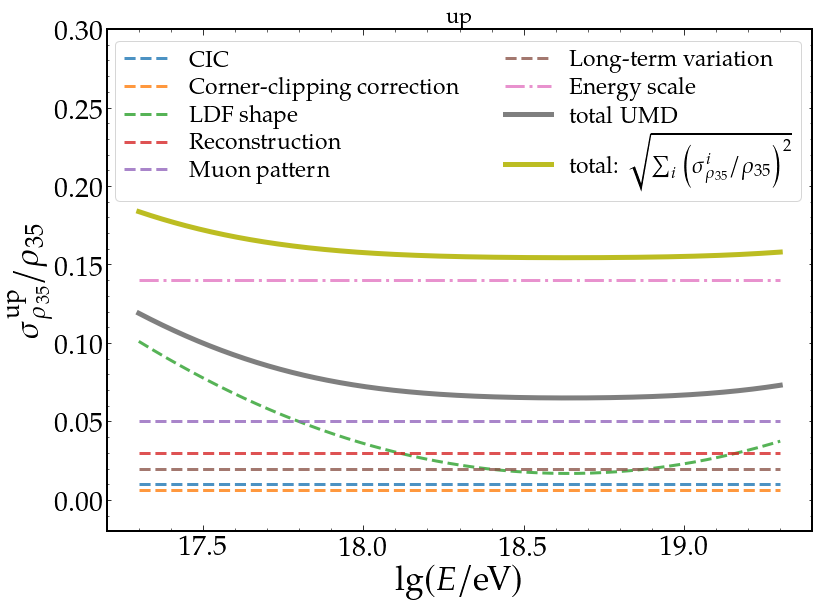

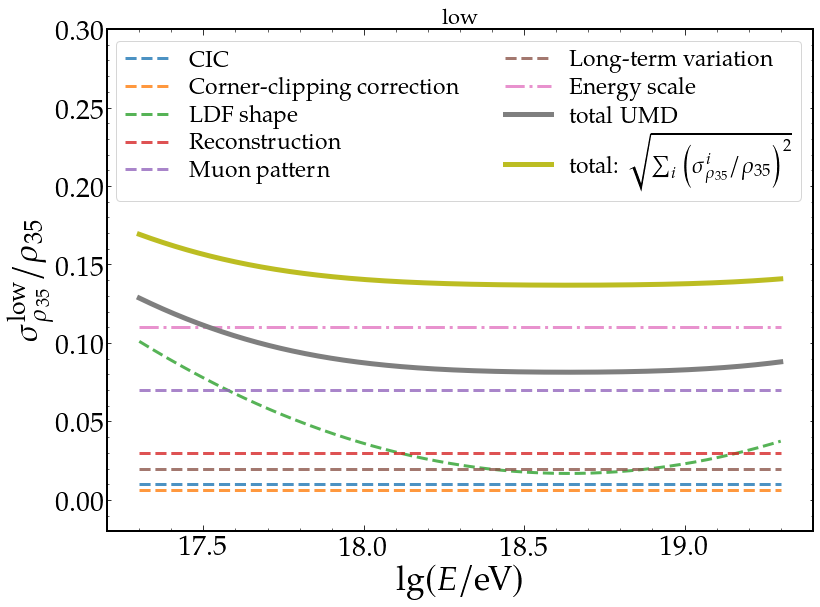

In [192]:
## plot of all systematic uncertainties 

lge_plot = np.linspace(min(lge_bin_edges), max(lge_bin_edges), 400)
lge_plot = np.linspace(min(lge_bin_edges), 19.3, 600)

def sigma_ldf(lge):
    return 0.047*(lge-18)**2 - 0.06*(lge-18) + 0.036

# I just take 3%
def sigma_rec(lge):
    #if lge < 18.7:
        #return 0.02
    #else:
        #return 0.06 
    return 0.03
    
sigma_long_term_plot = np.array([0.02 for ll in lge_plot])
sigma_att_plot = np.array([0.01 for ll in lge_plot])
sigma_pcc_plot = np.array([0.006 for ll in lge_plot])
sigma_ldf_plot = np.array([sigma_ldf(ll) for ll in lge_plot])
sigma_rec_plot = np.array([sigma_rec(ll) for ll in lge_plot])
sigma_up_pattern_plot = np.array([0.05 for ll in lge_plot])
sigma_low_pattern_plot = np.array([0.07 for ll in lge_plot])    
sigma_up_energy = np.array([0.14 for ll in lge_plot])
sigma_low_energy = np.array([0.11 for ll in lge_plot])


# should I include the fiber?
#sigma_fiber = np.array([0.015 for ll in lge_plot])

total_up = np.sqrt(sigma_att_plot**2 + sigma_pcc_plot**2 + sigma_ldf_plot**2 + 
               sigma_rec_plot**2 + sigma_up_pattern_plot**2 + sigma_up_energy**2 +
                  sigma_long_term_plot**2)

total_low = np.sqrt(sigma_att_plot**2 + sigma_pcc_plot**2 + sigma_ldf_plot**2 + 
               sigma_rec_plot**2 + sigma_low_pattern_plot**2 + sigma_low_energy**2 +
                   sigma_long_term_plot**2)

# total sys without energy scale
total_umd_up = np.sqrt(sigma_att_plot**2 + sigma_pcc_plot**2 + sigma_ldf_plot**2 + 
               sigma_rec_plot**2 + sigma_up_pattern_plot**2 + sigma_long_term_plot**2)

total_umd_low = np.sqrt(sigma_att_plot**2 + sigma_pcc_plot**2 + sigma_ldf_plot**2 + 
               sigma_rec_plot**2 + sigma_low_pattern_plot**2 + sigma_long_term_plot**2)

lw = 3
alpha = 0.8

# sigma up
fig, ax = plt.subplots(1, 1, figsize=(14, 9))

ax.set_title("up")
ax.plot(lge_plot, sigma_att_plot, label="CIC", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_pcc_plot, label=r"Corner-clipping correction", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_ldf_plot, label="LDF shape", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_rec_plot, label="Reconstruction", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_up_pattern_plot, label="Muon pattern", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_long_term_plot, label="Long-term variation", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_up_energy, label="Energy scale", lw=lw, ls="-.", alpha=alpha)

ax.plot(lge_plot, total_umd_up, label="total UMD", lw=5)
ax.plot(lge_plot, total_up, label=r"total: $\sqrt{ \sum_i \left(\sigma^{i}_{\rho_{35}} / \rho_{35}\right)^2 }$", lw=5)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=34)
ax.set_ylabel(r"$\sigma_{\rho_{35}}^\text{up} / \rho_{35}$", fontsize=34)

ax.tick_params(axis='both', which='major', labelsize=28)

ax.set_ylim([-0.02, 0.3])

ax.legend(loc="upper right", ncol=2, fontsize=23)

figname = "total_rel_sys_up.pdf"
fig.savefig(figname, bbox_inches="tight")

# sigma low
fig, ax = plt.subplots(1, 1, figsize=(14, 9))

ax.set_title("low")
ax.plot(lge_plot, sigma_att_plot, label="CIC", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_pcc_plot, label=r"Corner-clipping correction", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_ldf_plot, label="LDF shape", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_rec_plot, label="Reconstruction", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_low_pattern_plot, label="Muon pattern", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_long_term_plot, label="Long-term variation", lw=lw, ls="--", alpha=alpha)
ax.plot(lge_plot, sigma_low_energy, label="Energy scale", lw=lw, ls="-.", alpha=alpha)

ax.plot(lge_plot, total_umd_low, label=r"total UMD", lw=5)
ax.plot(lge_plot, total_low, label=r"total: $\sqrt{ \sum_i \left(\sigma^{i}_{\rho_{35}} / \rho_{35}\right)^2 }$", lw=5)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=34)
ax.set_ylabel(r"$\sigma_{\rho_{35}}^\text{low} / \rho_{35}$", fontsize=34)

ax.tick_params(axis='both', which='major', labelsize=28)
ax.set_ylim([-0.02, 0.3])

ax.legend(loc="upper right", ncol=2, fontsize=23)

figname = "total_rel_sys_low.pdf"
fig.savefig(figname, bbox_inches="tight")

In [7]:
def sys_umd_up(lge):
    """
    Systematic error up of UMD measurement (without energy scale)
    """
    error_cic = 0.01
    error_pcc = 0.006
    error_reco = sigma_rec(lge)
    error_ldf = sigma_ldf(lge)
    error_pattern_up = 0.05
    
    value = np.sqrt(error_cic**2 + error_pcc**2 + error_reco**2 + error_ldf**2 +
                    error_pattern_up**2)
    return value

def sys_umd_low(lge):
    """
    Systematic error low of UMD measurement (without energy scale)
    """
    error_cic = 0.01
    error_pcc = 0.006
    error_reco = sigma_rec(lge)
    error_ldf = sigma_ldf(lge)
    error_pattern_low = 0.07
    
    value = np.sqrt(error_cic**2 + error_pcc**2 + error_reco**2 + error_ldf**2 +
                    error_pattern_low**2)
    return value

def sys_up(lge):
    """
    Systematic error up of UMD measurement considering energy scale
    """
    error_energy_up = 0.14
    value = np.sqrt(sys_umd_up(lge)**2 + error_energy_up**2)
    
    return value

def sys_low(lge):
    """
    Systematic error low of UMD measurement considering energy scale
    """
    error_energy_low = 0.11
    value = np.sqrt(sys_umd_low(lge)**2 + error_energy_low**2)
    
    return value

events with standard reco = 13256


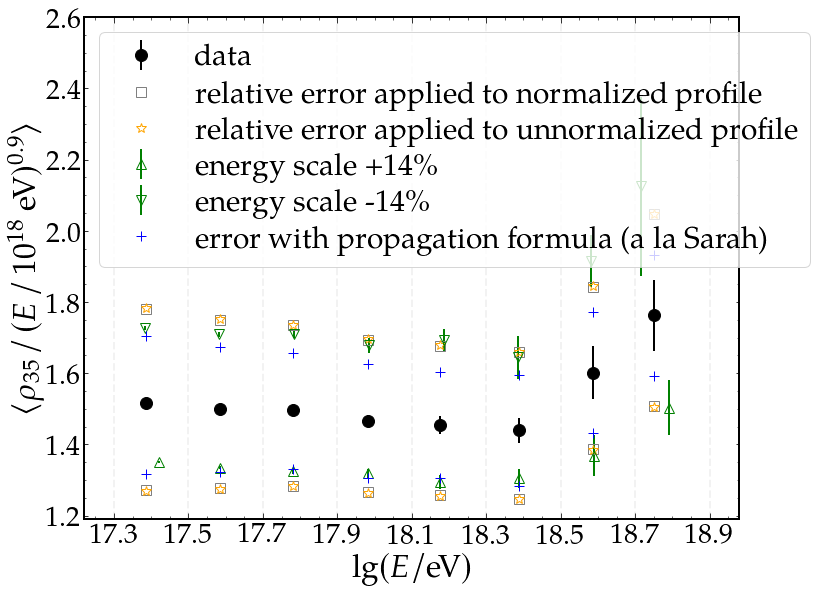

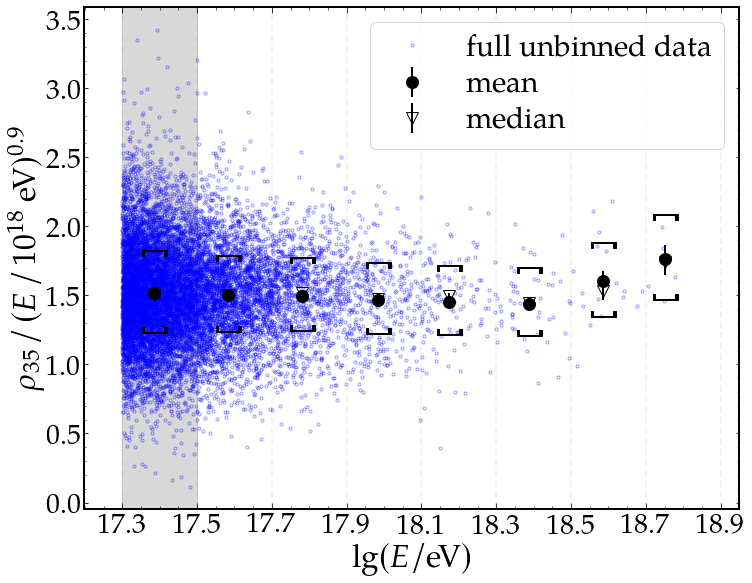

In [10]:
# Plot profile of data along with various different ways of computing 
# systematic uncertainties, just to see the dont vary much between each other

# Here I plot profile of rho35 / (E/10**18)**alpha vs energy with total sys uncertainty.
# also plot the profile with energy shifted, to check that the shifted values are actually 
# contained in the systematics
# I also plot the systematics with the alternative formula taking into account
# the correlation of rho35 with E (used by Sarah)

indir = "./different_muon_patterns/"

# edges of the energy binning for the profile
plot_highest_energy_events = False
if plot_highest_energy_events:
    lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.35]
    xticks = np.arange(17.3, 19.4, step=0.4)
else:
    lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9]
    xticks = lge_bin_edges
    

    
lge_bin_centers = lge_bin_edges[:-1] + np.diff(lge_bin_edges) / 2

# standard reconstruction
df = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                 delim_whitespace=True)
df = df[ df["lge"] > 17.3 ]
print(f"events with standard reco = {len(df)}")


# systematics
# I first need to make profile of rho35 vs lge
p = profile(df["lge"].to_numpy(), df["rho_att_corrected"].to_numpy())
p.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

rho_sys_up_ = np.array(p.profiley) * np.array([sys_up(ppp) for ppp in p.profilexmean]) / ( (10**np.array(p.profilexmean) / 10**18)**alpha )
rho_sys_low_ = np.array(p.profiley) * np.array([sys_low(ppp) for ppp in p.profilexmean])  / ( (10**np.array(p.profilexmean) / 10**18)**alpha )


# profile of rho35 / (E/10**18)**alpha vs energy
alpha = 0.9
fig, ax = plt.subplots(1, 1, figsize=(13, 9))

energy = 10**df["lge"].to_numpy()
norm_factor = (energy / (10**(18)) )**alpha
rho_norm = df["rho_att_corrected"].to_numpy() / norm_factor
p_norm = profile(df["lge"].to_numpy(), rho_norm)
p_norm.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)
#ax.errorbar(df["lge"].to_numpy(), rho_norm, mfc="None", ms=2, alpha=0.5, fmt="o")

# shifting energy scale +14%
e_plus = energy*1.14
norm_factor_plus = (e_plus / (10**(18)) )**alpha
rho_norm_plus = df["rho_att_corrected"].to_numpy() / norm_factor_plus
p_norm_plus = profile(np.log10(e_plus), rho_norm_plus)
p_norm_plus.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# shifting energy scale -14%
e_minus = energy*(1-0.14)
norm_factor_minus = (e_minus / (10**(18)) )**alpha
rho_norm_minus = df["rho_att_corrected"].to_numpy() / norm_factor_minus
p_norm_minus = profile(np.log10(e_minus), rho_norm_minus)
p_norm_minus.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# compute systematic error for each data point
rho_sys_up = np.array(p_norm.profiley) * np.array([sys_up(ppp) for ppp in p_norm.profilexmean])
rho_sys_low = np.array(p_norm.profiley) * np.array([sys_low(ppp) for ppp in p_norm.profilexmean])

ax.errorbar(p_norm.profilexmean, p_norm.profiley, yerr=p_norm.profileyerr,
           fmt="o", label=r"data",
           ms=12, color="k")

# one method (official) to compute systematic uncertainty
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) + rho_sys_up, 
            ms=10, mfc="None", fmt="s", color="grey", 
            label="relative error applied to normalized profile")
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) - rho_sys_low, 
            ms=10, mfc="None", fmt="s", color="grey")

# other method (applying error to rho35 and then normalizing)
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) + rho_sys_up_, 
            ms=10, mfc="None", fmt="*", color="orange", 
            label="relative error applied to unnormalized profile")
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) - rho_sys_low_, 
            ms=10, mfc="None", fmt="*", color="orange")

# profiles shifting energy scale only (just to check is contained in the systematics)
ax.errorbar(p_norm_plus.profilexmean, p_norm_plus.profiley, yerr=p_norm_plus.profileyerr,
           fmt="^", label=r"energy scale +14$\%$",
           ms=10, color="g", mfc="None")

ax.errorbar(p_norm_minus.profilexmean, p_norm_minus.profiley, yerr=p_norm_minus.profileyerr,
           fmt="v", label=r"energy scale -14$\%$",
           ms=10, color="g", mfc="None")



############################################
############################################
## computing error a la Sarah: error on rho35 + error on energy + correlation term (see first cells)

g = np.array(p_norm.profiley)

# relative errors
rho35_sys_up = np.array([sys_umd_up(ll) for ll in p_norm.profilexmean])
rho35_sys_low = np.array([sys_umd_low(ll) for ll in p_norm.profilexmean])

sys_tot_up, sys_tot_low = [], []
for i, lge_center in enumerate(lge_bin_centers):
    # bin edges
    lge1, lge2 = lge_bin_edges[i], lge_bin_edges[i+1]
    df_bin = df[ (lge1 < df["lge"]) & (df["lge"] < lge2) ]
    e_bin = 10**(df_bin["lge"].to_numpy())
    rho35_bin = (df_bin["rho_att_corrected"].to_numpy())
    
    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(e_bin, rho35_bin)
    correlation_coefficient = correlation_matrix[0, 1]
    
    rel_rho_up = sys_umd_up(lge_center)
    rel_rho_low = sys_umd_low(lge_center)
    rel_energy = 0.14
    
    sys_tot_up_value = g[i] * np.sqrt(rel_rho_up**2 + (alpha*rel_energy)**2 - 
                                      2*alpha*correlation_coefficient*rel_energy*rel_rho_up)
    sys_tot_low_value = g[i] * np.sqrt(rel_rho_low**2 + (alpha*rel_energy)**2 - 
                                      2*alpha*correlation_coefficient*rel_energy*rel_rho_low)
    
    sys_tot_up.append(sys_tot_up_value)
    sys_tot_low.append(sys_tot_low_value)

sys_tot_up = np.array(sys_tot_up)
sys_tot_low = np.array(sys_tot_low)

ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) + sys_tot_up, 
            ms=10, mfc="None", fmt="+", color="b", 
            label="error with propagation formula (a la Sarah)")
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) - sys_tot_low, 
            ms=10, mfc="None", fmt="+", color="b")  

# bin edges
for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
             fontsize=32)
ax.set_xticks(xticks)
ax.set_yticks(np.arange(1.2, 2.601, step=0.2))
ax.legend(fontsize=30, loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=28)



########################################################
########################################################
### Final plot of data with systematic errors 
plot_unbinned_data = True


fig, ax = plt.subplots(1, 1, figsize=(13, 9))

# unbinned data
if plot_unbinned_data:
    ax.errorbar(df["lge"].to_numpy(), rho_norm, mfc="None", ms=3, alpha=0.4, 
            fmt="o", color="b", label="full unbinned data")
    ax.set_ylabel(rf"$\rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}$",
             fontsize=32)
    loc_legend = "upper right"
else:
    #ax.set_yticks(np.arange(1.2, 2.201, step=0.1))
    ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
                 fontsize=32)
    loc_legend = "upper left"
    # put number of events in each data energy bin
    for i, _ in enumerate(p_norm.profilexmean):
        n = len(p_norm.profileydistributions[i])
        txt_evts = f"{n}"
        x_coord, y_coord = p_norm.profilexmean[i], p_norm.profiley[i]
        
        ax.text(x=x_coord, y=y_coord*0.9, s=txt_evts,
               fontsize=18)

ax.errorbar(p_norm.profilexmean, p_norm.profiley, yerr=p_norm.profileyerr,
           fmt="o", label=r"mean",
           ms=12, color="k")
ax.errorbar(p_norm.profilexmean, p_norm.profileymedian, yerr=p_norm.profileyiql,
           fmt="v", label=r"median", mfc="None",
           ms=12, color="k")

# official method to compute systematic uncertainty
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) + rho_sys_up, 
            ms=25,  marker=bracket_up, color="k", linestyle="None")
ax.errorbar(p_norm.profilexmean, np.array(p_norm.profiley) - rho_sys_low, 
            ms=25, marker=bracket_down, color="k", linestyle="None")

# bin edges
for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

# shaded area below full effiency threshold of 17.5
ax.axvspan(xmin=17.3, xmax=17.5, color="grey", alpha=0.3)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)

ax.set_xticks(xticks)

ax.legend(fontsize=30, loc=loc_legend)
#ax.set_xlim(right=18.92)
ax.set_xlim(right=max(lge_bin_edges)+0.05)

ax.tick_params(axis='both', which='major', labelsize=28)

figname = f"rho_norm_vs_e_unbinned{int(plot_unbinned_data)}.pdf"
fig.savefig(figname, bbox_inches="tight")

## Further checks

In [2]:
# just out of curiosity, plot also the profiles with noRej and ldfSarah
# noRej: reconstruction run without the condition of rejecting modules with
# too low signal
# ldfSarah: reconstruction run with the fixed shape parameters of the LDF used
# for the PMT paper (alpha=0.3, gamma=4.6, r0=280), but leaving beta free

indir = "./different_reconstructions/"

# standard 
df = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50.dat",
                 delim_whitespace=True)
df = df[ df["lge"] > 17.3 ]
print(f"standard = {len(df)}")

# standard with beta always free
df_betafree = pd.read_csv(indir + "unbinned_dataset_fixBeta0_time0_like3_fixCore1_useSil0_nOnes4_md6t50.dat",
                 delim_whitespace=True)
df_betafree = df_betafree[ df_betafree["lge"] > 17.3 ]
print(f"standard with beta always freee = {len(df_betafree)}")


# LDF with fixed shape parameters of PMT paper, beta free
df_sarah = pd.read_csv(indir + "unbinned_dataset_fixBeta0_time0_like3_fixCore1_useSil0_nOnes4_md6t50_ldfSarah.dat",
                 delim_whitespace=True)
df_sarah = df_sarah[ df_sarah["lge"] > 17.3 ]
print(f"events with sarah LDF = {len(df_sarah)}")

# reco without the rejection criteria
df_norej = pd.read_csv(indir + "unbinned_dataset_fixBeta1_time0_like3_fixCore0_useSil0_nOnes4_md6t50_noRej.dat",
                 delim_whitespace=True)
df_norej = df_norej[ df_norej["lge"] > 17.3 ]
print(f"events with no rejection criteria = {len(df_norej)}")


standard = 13256
standard with beta always freee = 13256
events with sarah LDF = 13256
events with no rejection criteria = 13349


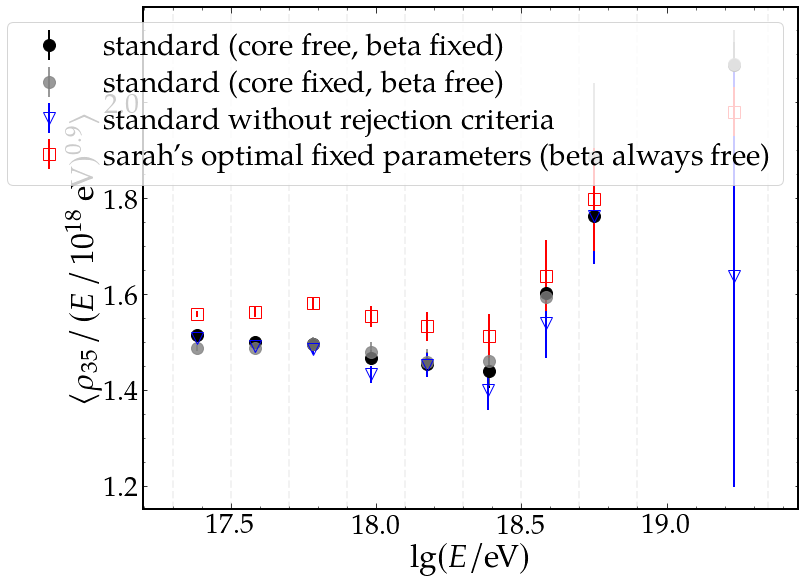

In [3]:
lge_bin_edges = [17.3, 17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.35]
alpha = 0.9

# TODO: deberia repetir la reconstruccion con la ldf de Sarah MAS la parametrizacion
# de beta que uso ella.

# standard
energy = 10**df["lge"].to_numpy()
norm_factor = (energy / (10**(18)) )**alpha
rho_norm = df["rho_att_corrected"].to_numpy() / norm_factor
p_norm = profile(df["lge"].to_numpy(), rho_norm)
p_norm.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# standard with beta always free
energy_betafree = 10**df_betafree["lge"].to_numpy()
norm_factor_betafree = (energy_betafree / (10**(18)) )**alpha
rho_norm_betafree = df_betafree["rho_att_corrected"].to_numpy() / norm_factor_betafree
p_norm_betafree = profile(df_betafree["lge"].to_numpy(), rho_norm_betafree)
p_norm_betafree.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# ldf sarah
energy_sarah = 10**df_sarah["lge"].to_numpy()
norm_factor_sarah = (energy_sarah / (10**(18)) )**alpha
rho_norm_sarah = df_sarah["rho_att_corrected"].to_numpy() / norm_factor_sarah
p_norm_sarah = profile(df_sarah["lge"].to_numpy(), rho_norm_sarah)
p_norm_sarah.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)

# reco without rejection criteria
energy_norej = 10**df_norej["lge"].to_numpy()
norm_factor_norej = (energy_norej / (10**(18)) )**alpha
rho_norm_norej = df_norej["rho_att_corrected"].to_numpy() / norm_factor_norej
p_norm_norej = profile(df_norej["lge"].to_numpy(), rho_norm_norej)
p_norm_norej.doProfile(xmin=min(lge_bin_edges), xmax=max(lge_bin_edges), bins=lge_bin_edges)


fig, ax = plt.subplots(1, 1, figsize=(13, 9))


ax.errorbar(p_norm.profilexmean, p_norm.profiley, yerr=p_norm.profileyerr,
           fmt="o", label=r"standard (core free, beta fixed)",
           ms=12, color="k")

ax.errorbar(p_norm_betafree.profilexmean, p_norm_betafree.profiley, 
            yerr=p_norm_betafree.profileyerr,
           fmt="o", label=r"standard (core fixed, beta free)",
           ms=12, color="grey", alpha=0.8)

ax.errorbar(p_norm_norej.profilexmean, p_norm_norej.profiley, yerr=p_norm_norej.profileyerr,
           fmt="v", label=r"standard without rejection criteria",
           ms=12, color="b", mfc="None")


ax.errorbar(p_norm_sarah.profilexmean, p_norm_sarah.profiley, yerr=p_norm_sarah.profileyerr,
           fmt="s", label=r"sarah's optimal fixed parameters (beta always free)",
           ms=12, color="r", mfc="None")

# bin edges
for edge in lge_bin_edges:
    ax.axvline(x=edge, ls="--", color="grey", alpha=0.1)

ax.set_xlabel(r"$\lg(E/\text{eV})$", fontsize=32)
ax.set_ylabel(rf"$\langle \rho_{{35}}  \, / \, (E \, / \, 10^{{18}} \text{{ eV}})^{{{alpha:.1f}}}\rangle$",
                 fontsize=32)

ax.legend(fontsize=30, loc="best")

ax.tick_params(axis='both', which='major', labelsize=28)

## closer look to the distributions

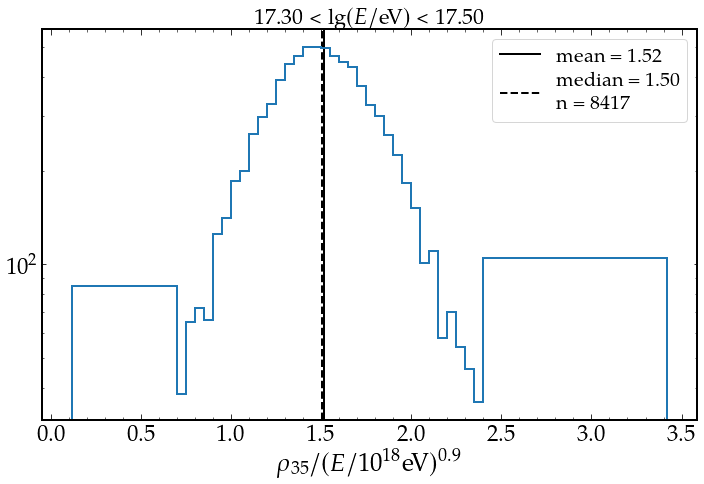

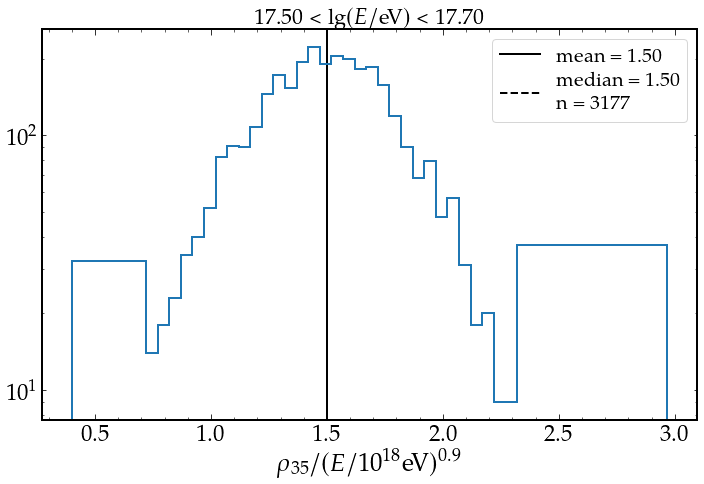

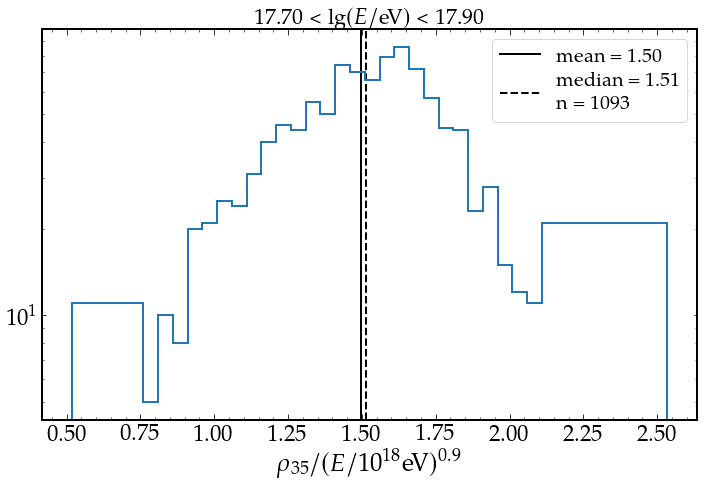

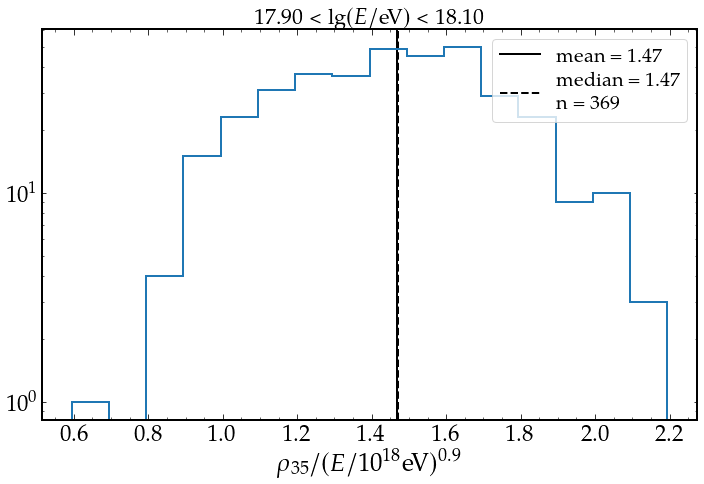

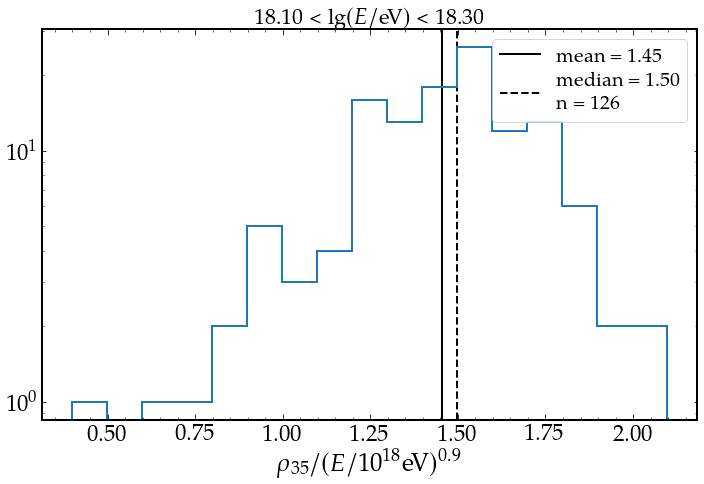

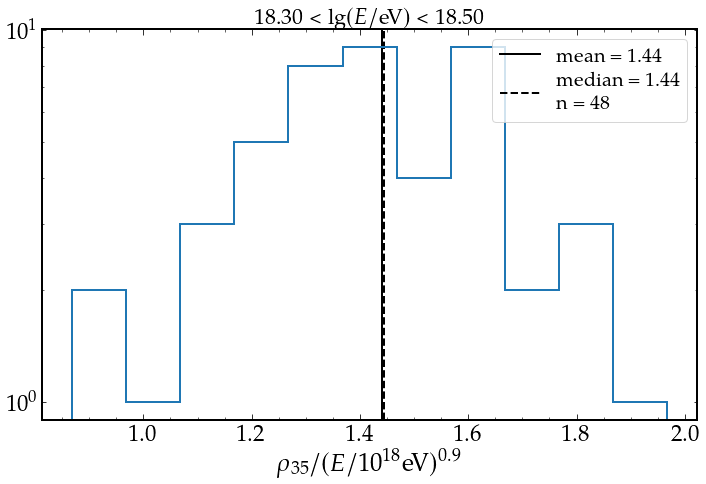

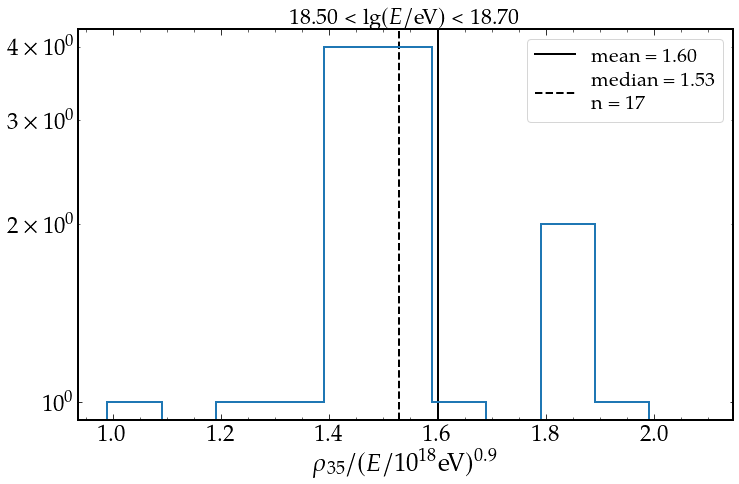

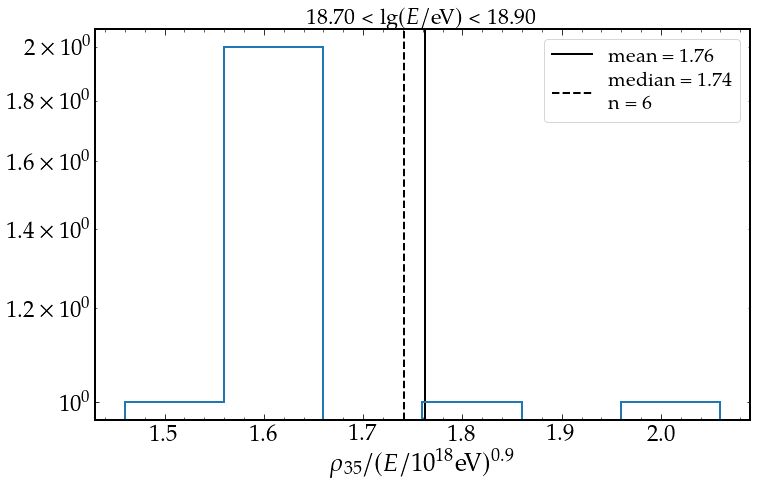

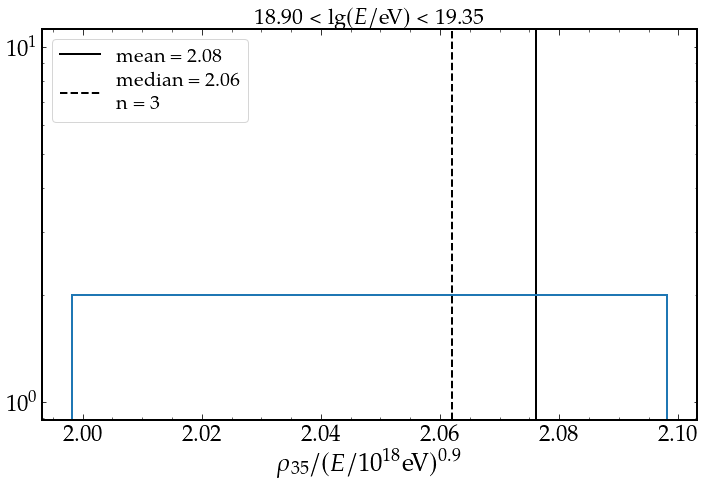

In [16]:
for i, dist in enumerate(p_norm.profileydistributions):
    fig, ax  = plt.subplots(1, 1, figsize=(13, 7))
    lge1, lge2 = p_norm.xbinedges[i], p_norm.xbinedges[i+1]
    title = rf"{lge1:.2f} < $ \lg(E/\text{{eV}})$ < {lge2:.2f}"
    
    n = len(dist)
    mean, median = np.mean(dist), np.median(dist)

    rho_min_quantile = np.quantile(dist, q=0.01)
    rho_max_quantile = np.quantile(dist, q=0.99)

    if n > 1000:
        rho_bin_edges = np.arange(rho_min_quantile, rho_max_quantile, step=0.05)
        rho_bin_edges = [min(dist)] + list(rho_bin_edges) + [max(dist)]
    else:
        rho_bin_edges = np.arange(min(dist), max(dist), step=0.1)
    
    ax.axvline(x=mean, ls="-", label=f"mean = {mean:.2f}")
    ax.axvline(x=median, ls="--", label=f"median = {median:.2f}\nn = {n}")
    ax.legend()
    
    ax.set_xlabel(rf"$\rho_{{35}} / (E / 10^{{18}} \text{{eV}})^{{{alpha:.1}}}$")
    
    ax.hist(dist, histtype="step", lw=2, bins=rho_bin_edges)
    ax.set_title(title)
    ax.set_yscale("log")

## Check on the full efficiency
Although the SD events seem to be fully efficient for theta < 45 above 17.3, I now check wether this holds for UMD events after the cuts. This is because the MdEventSelector rejects events with less than three counters with no muons.


dof = 6


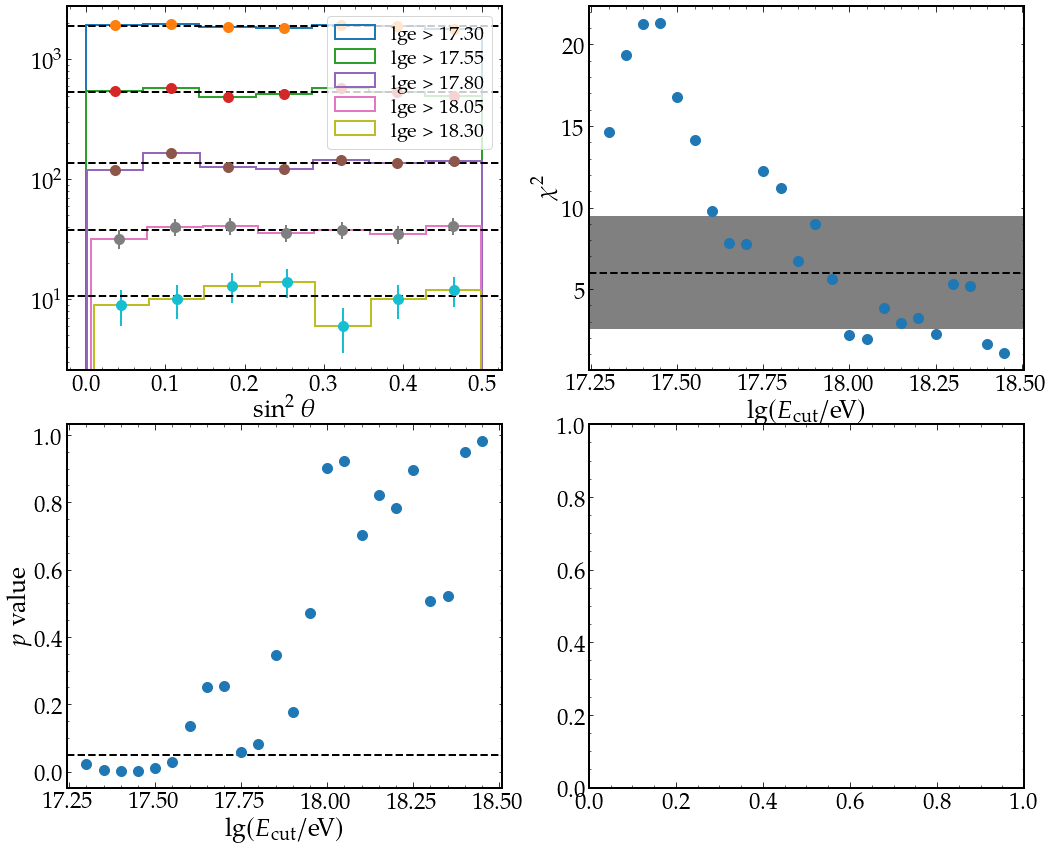

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(19, 14))
ax = ax.flatten()

nbins_sin2 = 7
dof = nbins_sin2 - 1 
lge_cuts = np.arange(17.3, 18.5, step=0.05)
chi2_values, pvalues = [], []

for i, lgec in enumerate(lge_cuts):
    df_cut = df[ df["lge"] > lgec ]
    #df_cut = df_cut[ df_cut["theta"] < 30 ]
    sin2 = np.sin(np.deg2rad(df_cut["theta"].to_numpy()))**2
    
    counts, bin_edges_sin2 = np.histogram(sin2, bins=nbins_sin2)
    counts_err = np.sqrt(counts)
    bin_centers = bin_edges_sin2[:-1] + np.diff(bin_edges_sin2)/2
        
    # expected number of counts in each bin if sin2 was uniform
    total_events = len(df_cut)
    nbins = len(bin_centers)
    assert nbins == nbins_sin2
    
    expected_counts = total_events / nbins 
    if i%5 == 0:
        ax[0].hist(sin2, bins=nbins, lw=2, histtype="step", label=f"lge > {lgec:.2f}")
        ax[0].errorbar(bin_centers, counts, yerr=counts_err, fmt="o")
        ax[0].axhline(y=expected_counts, ls="--")
    
    # chi in each bin 
    chi_ = (counts - expected_counts)**2 / (counts_err)**2
    chi2_observed = sum(chi_)
    
    chi2_values.append(chi2_observed)
    
    
    
    pval = chi2(df=dof).sf(chi2_observed)
    
    pvalues.append(pval)

print(f"dof = {dof}")

ax[0].set_yscale("log")
ax[0].set_xlabel(r"$\sin^2 \theta$")
ax[0].legend()

ax[1].set_xlabel(r"$\lg(E_\text{cut} / \text{eV}) $")
ax[1].set_ylabel(r"$\chi^2$")
ax[1].errorbar(lge_cuts, chi2_values, fmt="o")
# expected value +- 1sigma of a chi2 distribution
ax[1].axhline(y=dof, ls="--", color="k")
ax[1].axhspan(ymin=dof-np.sqrt(2*dof), ymax=dof+np.sqrt(2*dof))

ax[2].set_xlabel(r"$\lg(E_\text{cut} / \text{eV}) $")
ax[2].set_ylabel(r"$p$ value")
ax[2].errorbar(lge_cuts, pvalues, fmt="o")
ax[2].axhline(y=0.05, ls="--", color="k")
